In [48]:
import pandas as pd
from ydata_profiling import ProfileReport
import openai
import re
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Dataset 1. Kaggle Gender

### Data Preprocessing

In [46]:
def filter_dataframe(df):
    # Keep 'unit_id', 'gender', 'sidebar_color', 'name', and 'user_timezone'
    # Remove specified columns
    columns_to_remove = [
        '_golden', '_unit_state', 'trusted_judgments', '_last_judgment_at', 'profile_yn',
        'gender:confidence', 'profile_yn:confidence', 'created', 'fav_number',
        'gender_gold', 'link_color', 'profile_yn_gold', 'profileimage',
        'retweet_count', 'tweet_coord', 'tweet_count', 'tweet_created', 
        'tweet_id'
    ]

    
    # Remove rows based on specific conditions
    df = df[df['gender'].isin(['female', 'male'])]  # Keep rows where gender is 'female' or 'male'
    df = df[df['gender:confidence'] >= 0.8]  # Keep rows with gender confidence >= 8.0
    df = df[df['profile_yn'] != 'no']  # Keep rows where profile_yn is not 'no'
    df = df.dropna(subset=['description','tweet_location', 'user_timezone' ])  # Remove rows with null 'description'
    df = df[df['text'].str.len() >= 70]  # Keep rows where text length >= 50
    df = df.drop(columns=columns_to_remove, errors='ignore')
    # Filter 'tweet_location' based on having a comma or starting with a capital letter
    location_condition = df['tweet_location'].str.contains(',', na=False) & df['tweet_location'].str.istitle()
    df = df[location_condition]


    return df

df = pd.read_csv('potential_dataset/kaggle_gender/gender-classifier-DFE-791531.csv', encoding='ISO-8859-1')
# Assuming 'input_df' is your input DataFrame
filtered_df = filter_dataframe(df)
filtered_df.to_csv('potential_dataset/kaggle_gender/filtered_kaggle.csv')

In [47]:
filtered_df

_unit_id  _trusted_judgments  gender  \
9      815719235                   3  female   
64     815719290                   3  female   
67     815719293                   3  female   
127    815719353                   3    male   
152    815719378                   3  female   
...          ...                 ...     ...   
19888  815739483                   3    male   
19927  815739522                   3    male   
20018  815753864                 255    male   
20035  815755887                 270  female   
20040  815756417                 253    male   

                                             description            name  \
9      Renaissance art historian, University of Notti...   GabrieleNeher   
64     Born in Czech Republic, live in Ireland, wanna...      Moonfell44   
67              Retired Bad Girl. \nÛ¢Û¢ QUEEN! Û¢Û¢     Miss_Masaya   
127                                        hollow heart.     downeysmile   
152    National Security & Foreign Policy Editor @CQN...        jenkoons   
...                                                  ...             ...   
19888  keeping it real, packing steal, getting high '...   Robbie_DeNiro   
19927  Veteran journalist, husband, father, foodie, h...     ShawnYonker   
20018  Research fellow @ceidotorg. Transport and urba...    marcscribner   
20035  25. love my friends & family. the color pink. ...  Cait89lovesTWD   
20040  Houston Chronicle Columnist  - ken.hoffman@chr...    KenChronicle   

      sidebar_color                                               text  \
9            FFFFFF  @Evielady just how lovely is the tree this yea...   
64           C6E2EE  https://t.co/nRN2mGLd2E\nAm I the only one who...   
67           DFDFDF  Please God, let me get a house that has a fire...   
127          FFFFFF  Stats for the day have arrived. 1 new unfollow...   
152          FFFFFF  Listen to @johnmdonnelly discussing his exclus...   
...             ...                                                ...   
19888        C0DEED  @ELCEEZUS he knows our generation very well an...   
19927        FFFFFF  Looks like Beachamp from @_danibatze and @PHSW...   
20018        BDDCAD  @ebwashington @binarybits OEM-owned Car2Go. OE...   
20035        FFFFFF  Beetlejuice is the perfect Halloween movie!!!!...   
20040             0  Discovered it in England. It's how they eat fi...   

                 tweet_location               user_timezone  
9          Nottingham, England.                   Amsterdam  
64           Waterford, Ireland                  Casablanca  
67     Scotland, United Kingdom                   Edinburgh  
127            Napoli, Campania                   Amsterdam  
152           Washington, D.C.   Eastern Time (US & Canada)  
...                         ...                         ...  
19888          Portland, Oregon                      Alaska  
19927            Salisbury, Md.  Eastern Time (US & Canada)  
20018     Brightwood Park, D.C.  Eastern Time (US & Canada)  
20035   Raleigh, North Carolina      Atlantic Time (Canada)  
20040            Houston, Texas  Central Time (US & Canada)  

[524 rows x 9 columns]

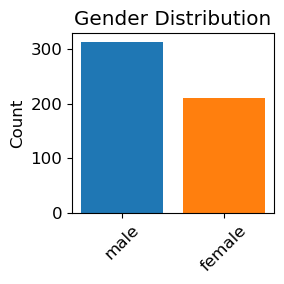

In [57]:
gender_counts = filtered_df['gender'].value_counts()

# Now, we'll plot the gender distribution with improved colors.
# Choosing a palette that is visually appealing.
colors = ['#1f77b4', '#ff7f0e']  # These are hex color codes for a blue and orange that should look nice on a plot.

plt.figure(figsize=(3,3))
plt.bar(gender_counts.index, gender_counts.values, color=colors)
plt.title('Gender Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotates the x-axis labels to prevent overlap
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()

### GPT Prompting

In [5]:
def chat(system, user_assistant, model_name='gpt-3.5-turbo'):
    assert isinstance(system, str), "`system` should be a string"
    assert isinstance(user_assistant, list), "`user_assistant` should be a list"
    system_msg = [{"role": "system", "content": system}]
    user_assistant_msgs = [
        {"role": "assistant", "content": user_assistant[i]} if i % 2 else {"role": "user", "content": user_assistant[i]}
        for i in range(len(user_assistant))]

    msgs = system_msg + user_assistant_msgs
    response = openai.ChatCompletion.create(model=model_name, messages=msgs)
    status_code = response["choices"][0]["finish_reason"]
    assert status_code == "stop", f"The status code was {status_code}."
    return response["choices"][0]["message"]["content"]

def process_row(row, model_name='gpt-3.5-turbo'):
    gender_prefix = "You are an expert in user gender guessing from attributes from the twitter user. Based on the following information about a user - Profile description, Username, A random tweet text written by the user, can you guess the user's gender? Directly output 'female' or 'male'. No reasoning needed."
    gender_guess = chat(gender_prefix, [row['description'], row['name'], row['text']], model_name=model_name)

    location_prefix = "You are an expert in location guessing from a list of text tweets from the same user. Can you tell me what city, province/state, country (in full name) is this user located, give me your top 5 guesses (without reasoning), in format of 1....; 2;... 3..."
    location_guess = chat(location_prefix, [row['text']], model_name=model_name)

    return gender_guess, location_guess
'''
# Adjust the process_row function to accept model_name and pass it to the chat function
def process_row(row, model_name='gpt-3.5-turbo'):
    prefix = "You are an expert in location guessing from a list of text tweets from the same user. Can you tell me what city, province/state, country (in full name) is this user located, give me your top 5 guesses (without reasoning), in format of 1....; 2;... 3..."
    text = row["text"]
    response = chat(prefix, [text], model_name=model_name)
    return response
'''


def find_accuracy(df, target_col, location_col = 'tweet_location', city_col='city', gender_col='gender'):
    # Assuming that your DataFrame has a 'gender_guess' column with the guessed genders
    # and a 'location_guesses' column with the top 5 location guesses
    if city_col not in df.columns:
        df[city_col] = df[location_col].str.split(',').str[0]
    # Calculate gender accuracy
    gender_accuracy = (df[gender_col] == df['gender']).mean()


    # Extract and process location guesses for top 1, top 3, and top 5
    df[target_col + '_top1'] = df[target_col].str.extract(r'1\. ([^\n]+)')
    df[target_col + '_top3'] = df[target_col].apply(lambda x: ";".join(x.split(";")[:3]))
    df[target_col + '_top5'] = df[target_col].str.replace(r'\d\.\s', '', regex=True)

    # Function to check if the city exists as a substring in the target column
    def check_city_in_target(row, column):
        if pd.isnull(row[city_col]) or pd.isnull(row[column]):
            return 0  # Handling possible null values to avoid errors
        return 1 if row[city_col].lower() in row[column].lower() else 0

    # Apply the function to create label columns for top 1, top 3, and top 5
    df[target_col + '_top1_label'] = df.apply(lambda row: check_city_in_target(row, target_col + '_top1'), axis=1)
    df[target_col + '_top3_label'] = df.apply(lambda row: check_city_in_target(row, target_col + '_top3'), axis=1)
    df[target_col + '_top5_label'] = df.apply(lambda row: check_city_in_target(row, target_col + '_top5'), axis=1)

    # Calculate accuracies for top 1, top 3, and top 5
    top1_accuracy = df[target_col + '_top1_label'].mean()
    top3_accuracy = df[target_col + '_top3_label'].mean()
    top5_accuracy = df[target_col + '_top5_label'].mean()

    # Print accuracies
    print(f"Gender Accuracy: {gender_accuracy:.2%}")
    print(f"Top 1 Location Accuracy from {target_col}: {top1_accuracy:.2%}")
    print(f"Top 3 Location Accuracy from {target_col}: {top3_accuracy:.2%}")
    print(f"Top 5 Location Accuracy from {target_col}: {top5_accuracy:.2%}")

    return df

In [192]:
df = filtered_df.head(100)
df[['gpt4_gender_guess', 'gpt4_location_guess']] = df.apply(lambda row: pd.Series(process_row(row, model_name='gpt-4-turbo')), axis=1)
df = find_accuracy(df, 'gpt4_location_guess', location_col='tweet_location', city_col='city', gender_col='gpt4_gender_guess')
df.to_csv('llm_output/kaggle/100sample_gpt4_output.csv')
df

Gender Accuracy: 82.00%
Top 1 Location Accuracy from gpt4_location_guess: 11.00%
Top 3 Location Accuracy from gpt4_location_guess: 18.00%
Top 5 Location Accuracy from gpt4_location_guess: 21.00%


_unit_id  _trusted_judgments  gender  \
9     815719235                   3  female   
64    815719290                   3  female   
67    815719293                   3  female   
127   815719353                   3    male   
152   815719378                   3  female   
...         ...                 ...     ...   
3029  815722324                   3    male   
3066  815722361                   3    male   
3074  815722369                   3    male   
3101  815722396                   3  female   
3120  815722415                   3    male   

                                            description            name  \
9     Renaissance art historian, University of Notti...   GabrieleNeher   
64    Born in Czech Republic, live in Ireland, wanna...      Moonfell44   
67             Retired Bad Girl. \nÛ¢Û¢ QUEEN! Û¢Û¢     Miss_Masaya   
127                                       hollow heart.     downeysmile   
152   National Security & Foreign Policy Editor @CQN...        jenkoons   
...                                                 ...             ...   
3029  Erasmus Mundus Scholar 2015-16. Love Politics,...   BulelaniMfaco   
3066  philosophy, economics, music, gardening, progr...     drewtheglue   
3074  18 | Ryerson - Ted Rogers School Of Management...  _TheKhanArtist   
3101  Interests: Cricket, Football, the Rams, Cyclin...  eleanor_morton   
3120                   I can be googled, therefore I am        kostpech   

     sidebar_color                                               text  \
9           FFFFFF  @Evielady just how lovely is the tree this yea...   
64          C6E2EE  https://t.co/nRN2mGLd2E\nAm I the only one who...   
67          DFDFDF  Please God, let me get a house that has a fire...   
127         FFFFFF  Stats for the day have arrived. 1 new unfollow...   
152         FFFFFF  Listen to @johnmdonnelly discussing his exclus...   
...            ...                                                ...   
3029        D3D2CF  Dear Mr President, I was hoping to see you at ...   
3066             0  @zerohedge TRUMP said CARSON cant make deals.....   
3074             0  Moral of the story. Just go around me, because...   
3101        FFFFFF  Baroness Meacher's motion to delay #taxcredits...   
3120        C0DEED  Found a Transponder Snail!\nKiller rabbits...!...   

                tweet_location               user_timezone gpt4_gender_guess  \
9         Nottingham, England.                   Amsterdam            female   
64          Waterford, Ireland                  Casablanca            female   
67    Scotland, United Kingdom                   Edinburgh            female   
127           Napoli, Campania                   Amsterdam              male   
152          Washington, D.C.   Eastern Time (US & Canada)              male   
...                        ...                         ...               ...   
3029      Dublin City, Ireland                    Pretoria              male   
3066       Hamtramck, Michigan  Eastern Time (US & Canada)              male   
3074          Toronto, Ontario  Pacific Time (US & Canada)            female   
3101     Dunfermline, Scotland                      London            female   
3120            Athens, Greece                      Athens              male   

                                    gpt4_location_guess         city  \
9     1. New York City, New York, United States;\n2....   Nottingham   
64    1. Los Angeles, California, United States;\n2....    Waterford   
67    1. Calgary, Alberta, Canada\n2. Denver, Colora...     Scotland   
127   1. New York City, New York, United States;\n2....       Napoli   
152   1. Washington, D.C., United States;\n2. Arling...   Washington   
...                                                 ...          ...   
3029  1. Pretoria, Gauteng, South Africa;\n2. Johann...  Dublin City   
3066  1. Washington, D.C., United States;\n2. New Yo...    Hamtramck   
3074  1. Los Angeles, California, United States;\n2....

In [199]:
df = filtered_df.iloc[200:300]
df[['gpt4_gender_guess', 'gpt4_location_guess']] = df.apply(lambda row: pd.Series(process_row(row, model_name='gpt-4-turbo')), axis=1)
df = find_accuracy(df, 'gpt4_location_guess', location_col='tweet_location', city_col='city', gender_col='gpt4_gender_guess')
df.to_csv('llm_output/kaggle/100to200_sample_gpt4_output.csv')
df

Gender Accuracy: 79.00%
Top 1 Location Accuracy from gpt4_location_guess: 14.00%
Top 3 Location Accuracy from gpt4_location_guess: 19.00%
Top 5 Location Accuracy from gpt4_location_guess: 25.00%


_unit_id  _trusted_judgments  gender  \
8252   815727575                   3    male   
8254   815727577                   3    male   
8302   815727631                   3    male   
8337   815727666                   3  female   
8465   815727794                   3    male   
...          ...                 ...     ...   
11830  815731227                   3  female   
11890  815731287                   3  female   
11906  815731307                   3    male   
11915  815731316                   3    male   
11923  815731324                   3  female   

                                             description             name  \
8252   #Digital Strategist. Global social marketing @...       Marc_Meyer   
8254            If you're reading this. You're a cunt :D            JDC99   
8302   Classical liberal. Fashion person. Exiled Geor...     grimesdarren   
8337   Senior Designer | Mother | Wife | Lover of all...    DianePKennedy   
8465   Get the latest IPO news first. We scan every f...       IPOSniffer   
...                                                  ...              ...   
11830  I left my notebook full of possible twitter bi...    jaureguiblaah   
11890  My mind's wide open like starry skies\nI ask G...    kerryraymond_   
11906                 Pro professional. SC: JColbyMalone  ColbyAndCompany   
11915  Author, speaker, professional networker, start...      pasquinilli   
11923  Passionate communicator for Migrant Help, omni...    JoBirchPhaure   

      sidebar_color                                               text  \
8252         87BC44  Whether big or small, tools &amp; resources fo...   
8254         C0DEED  The Soup has vaguely tangental crossover with ...   
8302              0  Labour have surely hammered the final nail int...   
8337         FFFFFF  Photo: #Repost @bulgariofficial ÄÈÄÈÄÈ Sens...   
8465         7A5C45  Equiniti attracts investors to support upcomin...   
...             ...                                                ...   
11830        C0DEED  SIRIUS IM CRYING I JUST WATCHED HIM DIE FOR LI...   
11890        FFFFFF  But if you like causing trouble up in hotel ro...   
11906        829D5E  This dude working out right next to Brian Hoye...   
11915        C0DEED  Listen Now To Episode 3! It's Real! Melbourne ...   
11923        FFFFFF  Peers vote to delay tax credit cuts and to pro...   

                   tweet_location                user_timezone  \
8252              Naples, Florida   Eastern Time (US & Canada)   
8254   Glenrothes, Fife, Scotland                       London   
8302           Brighton, England                        London   
8337     Northern Beaches, Sydney                       Sydney   
8465              London, England                   Casablanca   
...                           ...                          ...   
11830             Llanelli, Wales   Pacific Time (US & Canada)   
11890                Amanda, Ohio                       Alaska   
11906               Compton, Tx.   Mountain Time (US & Canada)   
11915             Kettering, Ohio   Eastern Time (US & Canada)   
11923         Folkestone, England                   Casablanca   

      gpt4_gender_guess                                gpt4_location_guess  \
8252               male  1. San Francisco, California, United States;\n...   
8254               male  1. Los Angeles, California, United States\n2. ...   
8302               male  1. London, England, United Kingdom;\n2. Manche...   
8337             female  1. Rome, Lazio, Italy;\n2. Milan, Lombardy, It...   
8465               male  1. London, England, United Kingdom;\n2. New Yo...   
...                 ...                                                ...   
11830            female  1. New York City, New York, United States;\n2....   
11890            female  1. Los Angeles, California, United States;\n2....   
11906              male  1. Boston, Massachusetts, United States;\n2. S...   
11915              male  1. Melbourne, Victo

In [203]:
df = filtered_df.iloc[300:400]
df[['gpt4_gender_guess', 'gpt4_location_guess']] = df.apply(lambda row: pd.Series(process_row(row, model_name='gpt-4-turbo')), axis=1)
df = find_accuracy(df, 'gpt4_location_guess', location_col='tweet_location', city_col='city', gender_col='gpt4_gender_guess')
df.to_csv('llm_output/kaggle/300to400_sample_gpt4_output.csv')
df

APIError: The server had an error while processing your request. Sorry about that! {
  "error": {
    "message": "The server had an error while processing your request. Sorry about that!",
    "type": "server_error",
    "param": null,
    "code": null
  }
} 500 {'error': {'message': 'The server had an error while processing your request. Sorry about that!', 'type': 'server_error', 'param': None, 'code': None}} {'Date': 'Wed, 10 Apr 2024 17:41:15 GMT', 'Content-Type': 'application/json', 'Content-Length': '175', 'Connection': 'keep-alive', 'openai-organization': 'truffle-security-co', 'openai-processing-ms': '402', 'openai-version': '2020-10-01', 'strict-transport-security': 'max-age=15724800; includeSubDomains', 'x-ratelimit-limit-requests': '10000', 'x-ratelimit-limit-tokens': '800000', 'x-ratelimit-remaining-requests': '9999', 'x-ratelimit-remaining-tokens': '799849', 'x-ratelimit-reset-requests': '6ms', 'x-ratelimit-reset-tokens': '11ms', 'x-request-id': 'req_b5831436828d36138d297204794bf04d', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '872486d09c23a22f-YYZ', 'alt-svc': 'h3=":443"; ma=86400'}

In [202]:
df = filtered_df.iloc[400:]
df[['gpt4_gender_guess', 'gpt4_location_guess']] = df.apply(lambda row: pd.Series(process_row(row, model_name='gpt-4-turbo')), axis=1)
df = find_accuracy(df, 'gpt4_location_guess', location_col='tweet_location', city_col='city', gender_col='gpt4_gender_guess')
df.to_csv('llm_output/kaggle/400to_sample_gpt4_output.csv')
df

Gender Accuracy: 74.19%
Top 1 Location Accuracy from gpt4_location_guess: 9.68%
Top 3 Location Accuracy from gpt4_location_guess: 13.71%
Top 5 Location Accuracy from gpt4_location_guess: 15.32%


_unit_id  _trusted_judgments  gender  \
15643  815735135                   3    male   
15668  815735160                   3  female   
15705  815735201                   3  female   
15745  815735241                   3    male   
15776  815735272                   3    male   
...          ...                 ...     ...   
19888  815739483                   3    male   
19927  815739522                   3    male   
20018  815753864                 255    male   
20035  815755887                 270  female   
20040  815756417                 253    male   

                                             description             name  \
15643  HR & OD Professional working for IBM; been in ...      DaveMillner   
15668  Ñ  I've got my hands full of unhealthy obsess...  shotwithsantana   
15705  My favourites - Textile design, Arizona, Japan...        cragchris   
15745  Husband, Father, Brother, Uncle | Canadian Nat...         t_chacra   
15776  DJ Adverb, Toronto, Ontario, HipHop, Funk, Mot...         DJAdverb   
...                                                  ...              ...   
19888  keeping it real, packing steal, getting high '...    Robbie_DeNiro   
19927  Veteran journalist, husband, father, foodie, h...      ShawnYonker   
20018  Research fellow @ceidotorg. Transport and urba...     marcscribner   
20035  25. love my friends & family. the color pink. ...   Cait89lovesTWD   
20040  Houston Chronicle Columnist  - ken.hoffman@chr...     KenChronicle   

      sidebar_color                                               text  \
15643             0  @mercedesamgF1 Please get rid of @nico_rosberg...   
15668        FFFFFF  ; @Slow_Trigger and I trying to talk to Dave l...   
15705        F2E195  Nice little jaunt to Edinburgh today. Lunch wi...   
15745        A8C7F7  I'll say it again, just eat REAL food! Limit r...   
15776        A8C7F7  Some pics from a a few weeks ago, played a sho...   
...             ...                                                ...   
19888        C0DEED  @ELCEEZUS he knows our generation very well an...   
19927        FFFFFF  Looks like Beachamp from @_danibatze and @PHSW...   
20018        BDDCAD  @ebwashington @binarybits OEM-owned Car2Go. OE...   
20035        FFFFFF  Beetlejuice is the perfect Halloween movie!!!!...   
20040             0  Discovered it in England. It's how they eat fi...   

                   tweet_location               user_timezone  \
15643           St Albans, London                      London   
15668  Nowhere, New Jersey // 19.  Eastern Time (US & Canada)   
15705     Lake District, Cumbria.                      London   
15745   Oakville, Ontario, Canada                       Quito   
15776            Toronto, Ontario  Eastern Time (US & Canada)   
...                           ...                         ...   
19888            Portland, Oregon                      Alaska   
19927              Salisbury, Md.  Eastern Time (US & Canada)   
20018       Brightwood Park, D.C.  Eastern Time (US & Canada)   
20035     Raleigh, North Carolina      Atlantic Time (Canada)   
20040              Houston, Texas  Central Time (US & Canada)   

      gpt4_gender_guess                                gpt4_location_guess  \
15643              male  1. London, England, United Kingdom;\n2. Melbou...   
15668              male  1. New York City, New York, United States;\n2....   
15705            female  1. Edinburgh, Scotland, United Kingdom;\n2. Gl...   
15745              male  1. Los Angeles, California, United States\n2. ...   
15776              male  1. Toronto, Ontario, Canada\n2. Montreal, Queb...   
...                 ...                                                ...   
19888              male  1. Toronto, Ontario, Canada\n2. New York, New ...   
19927            female  1. Beach Haven, New Jersey, United States;\n2....   
20018              male  1. San Francisco, California, United States\n2...   
20035            female  1. Los Angeles, California, Uni

# Dataset 2. Twitter CIKM

### Data Preprocessing

In [20]:
# Read the first file with user IDs and locations
users_df = pd.read_csv('twitter_cikm_2010/training_set_users.txt', delimiter='\t', header=None, names=['user_id', 'location'])

# Read the file, skipping bad lines
tweets_df = pd.read_csv('twitter_cikm_2010/training_set_tweets.txt', delimiter='\t', header=None, 
                        names=['user_id', 'tweet_id', 'tweet_text', 'timestamp'],
                        on_bad_lines='skip')

In [21]:

# Function to remove mentions at the beginning of a tweet
def remove_mentions(tweet):
    if tweet.startswith('@'):
        return tweet.split(' ', 1)[1] if ' ' in tweet else ''
    else:
        return tweet

def clean_tweet_text(df, column='tweet_text'):
    """
    Processes the DataFrame by:
    1. Removing rows where tweet_text is null.
    2. Removing rows where the tweet_text starts with "RT @".
    3. Removing substrings starting from "http://" up to the next space or the end of the entry.
    4. Removing mentions that start with '@' at the beginning of a tweet.
    5. Removing tweets that are less than 100 characters long.

    Parameters:
    - df: DataFrame to process.
    - column: The name of the column containing the tweet text. Defaults to 'tweet_text'.

    Returns:
    - DataFrame with the specified text processing applied.
    """
    # Remove rows where 'tweet_text' is null
    df = df.dropna(subset=[column])

    # Remove "RT @" part up to the first space
    # df[column] = df[column].str.replace(r'RT @\S+', '', regex=True)


    # Define a function to remove "http://" substrings
    def remove_http(text):
        return re.sub(r'http://[^\s]*', '', text)

    # Apply the functions to clean up the tweet text
    # df[column] = df[column].apply(remove_http).apply(remove_mentions)

    # Remove tweets that are less than 100 characters long
    df = df[df[column].str.len() >= 100]

    return df


cleaned_tweets_df = clean_tweet_text(tweets_df.copy())
cleaned_tweets_df


user_id      tweet_id  \
4        60730027    6315879930   
5        60730027    6314008277   
6        60730027    6313959103   
7        60730027    6313919319   
8        60730027    6313880396   
...           ...           ...   
3807518  18000542  4325193046.0   
3807519  18000542  4342009889.0   
3807547  15728619  4318704637.0   
3807554  15728619  4319700862.0   
3807568  70604115  4161273709.0   

                                                tweet_text  \
4        @smokinvinyl danny boy! wanna check out d-nice...   
5        ...and if you have ppl that you care about, ma...   
6        ...that shit weighs heavy on me.  take respons...   
7        ...including his last failed relationship.  an...   
8        so...I got a string of texts last night from s...   
...                                                    ...   
3807518  It's my birthday so I decided to celebrate wit...   
3807519  Grow Your Business with Intention. If you want...   
3807547  @ChrisHiter haha, no. its pride vs payroll. ha...   
3807554  I approve. He gets an 8. Intelligence would ha...   
3807568  I&#39;m so fucking excited for 8 o&#39;clock t...   

                   timestamp  
4        2009-12-03 15:39:10  
5        2009-12-03 14:26:33  
6        2009-12-03 14:24:40  
7        2009-12-03 14:23:07  
8        2009-12-03 14:21:36  
...                      ...  
3807518  2009-09-23 16:07:38  
3807519  2009-09-24 08:55:07  
3807547  2009-09-23 11:12:43  
3807554  2009-09-23 11:56:41  
3807568  2009-09-21 20:09:00  

[1481228 rows x 4 columns]

In [22]:
users_df

user_id               location
0             14          San Francisco
1             15          San Francisco
2             18      San Francisco, CA
3       19922973            Chicago, IL
4       63963170               New York
...          ...                    ...
115881   9437102            Raleigh, NC
115882  18000542             Dallas, TX
115883  55574468          Pensacola, FL
115884  15728619  Woburn, Massachusetts
115885  70604115          Clarkston, WA

[115886 rows x 2 columns]

In [23]:
# Merge the dataframes on the 'user_id' column
merged_df = pd.merge(cleaned_tweets_df, users_df, on='user_id', how='left')
merged_df= merged_df.dropna(subset=['location'])
merged_df = merged_df.drop_duplicates()
merged_df

user_id    tweet_id  \
1155489  25189732  4078727149   
1155490  25189732  4102835306   
1155491  25189732  4109631991   
1155492  25189732  4115199283   
1155493  25189732  4115218456   
...           ...         ...   
1520207  18348823  4125577111   
1520208  18348823  4126614032   
1520209  20963987  4357329848   
1520210  20963987  4376347335   
1520211  20963987  4376359170   

                                                tweet_text  \
1155489  Gnna catch urself a WERE-grl ;) RT @nc17ofburl...   
1155490  @retrojayne Amanda seyfried was SO Buffy in th...   
1155491  Omg live traxxxx-R done!!! I'm so happy with t...   
1155492  Insanely busy day! good busy but still tired! ...   
1155493  Can't wait 2 see all u beautiful ppl at Webste...   
...                                                    ...   
1520207  You even say, "I know the kids are mine! But t...   
1520208  Rehearsal in an hour at the ACTCo office for "...   
1520209  @HafDoc lol i just said that to my friend and ...   
1520210  @HafDoc lol yeah i don't mind them RT-ing my f...   
1520211  @HafDoc lol in the picture my friend @zeenakur...   

                   timestamp       location  
1155489  2009-09-18 08:09:00   New York, NY  
1155490  2009-09-19 09:09:00   New York, NY  
1155491  2009-09-19 15:09:00   New York, NY  
1155492  2009-09-19 21:09:00   New York, NY  
1155493  2009-09-19 21:09:00   New York, NY  
...                      ...            ...  
1520207  2009-09-20 10:09:00     Vienna, VA  
1520208  2009-09-20 11:09:00     Vienna, VA  
1520209  2009-09-24 20:35:51  Dallas, Texas  
1520210  2009-09-25 14:41:45  Dallas, Texas  
1520211  2009-09-25 14:42:19  Dallas, Texas  

[231157 rows x 5 columns]

In [24]:
grouped_df = merged_df.groupby('user_id').agg({
    'tweet_id': lambda x: list(x),
    'tweet_text': lambda x: '\n'.join(x),
    'location': 'first'  # Aggregating the first 'location' value from each group
}).rename(columns={'location': 'raw_location'}).reset_index()  # Renaming the 'location' column to 'raw_location'

grouped_df

user_id                                           tweet_id  \
0          4999  [4065800601, 4066074594, 4085655262, 408579500...   
1          8610  [4324726203, 4326221640, 4326993477, 432953381...   
2         10202                           [4102311972, 4102321119]   
3         11730   [4176343010, 4386390114, 4387429792, 4404611198]   
4         18553  [3994070570, 3994523032, 4013390210, 401620982...   
...         ...                                                ...   
31184  77695580   [4413559884, 4413852994, 4415711153, 4427010644]   
31185  77721881                           [4416411236, 4418140634]   
31186  77739255                           [4417071076, 4417279324]   
31187  77879371  [4430817843, 4430844333, 4430887186, 443145986...   
31188  77883912  [4430971255, 4430978044, 4430985048, 443099046...   

                                              tweet_text  \
0      There should be a word for the feeling you get...   
1      Go Houston!!! RT @KTRKHouston: City of Houston...   
2      @amcmoore - hmmm. You could. Depends how passi...   
3      I've got a head cold, but it's not stopping me...   
4      really? does no one believe that I can have a ...   
...                                                  ...   
31184  You need your own Online Business Card now. Re...   
31185  So it seems Twitter and my phone don't get alo...   
31186  NOva WAT sezona 2010 je počela! Za prijave do ...   
31187  Apple expected to release redesigned polycarbo...   
31188  Yeah, so I put together this whole series of k...   

                raw_location  
0              San Francisco  
1             Houston, Texas  
2                 Boston, MA  
3                Seattle, WA  
4      Des Plaines, Illinois  
...                      ...  
31184            Los Angeles  
31185                Chester  
31186               Belgrade  
31187          Cupertino, CA  
31188                Wichita  

[31189 rows x 4 columns]

In [221]:
# Assuming grouped_df is already created as per the previous code
# Now, filter the DataFrame to keep only rows where 'tweet_id' has more than three elements
grouped_df = grouped_df[grouped_df['tweet_id'].apply(lambda x: len(x) > 3)]
grouped_df

user_id                                           tweet_id  \
0          4999  [4065800601, 4066074594, 4085655262, 408579500...   
1          8610  [4324726203, 4326221640, 4326993477, 432953381...   
3         11730   [4176343010, 4386390114, 4387429792, 4404611198]   
4         18553  [3994070570, 3994523032, 4013390210, 401620982...   
5         24013   [4061687779, 4086277652, 4300461221, 4303141517]   
...         ...                                                ...   
31181  77662967   [4411010556, 4416798240, 4416869555, 4416977277]   
31183  77694976  [4414394359, 4414398377, 4414400488, 441440257...   
31184  77695580   [4413559884, 4413852994, 4415711153, 4427010644]   
31187  77879371  [4430817843, 4430844333, 4430887186, 443145986...   
31188  77883912  [4430971255, 4430978044, 4430985048, 443099046...   

                                              tweet_text  \
0      There should be a word for the feeling you get...   
1      Go Houston!!! RT @KTRKHouston: City of Houston...   
3      I've got a head cold, but it's not stopping me...   
4      really? does no one believe that I can have a ...   
5      anyone have problems getting on wifi on campus...   
...                                                  ...   
31181  About to read my word and if god comes tonite ...   
31183  songthatmademecry iamsinglebecause Philippines...   
31184  You need your own Online Business Card now. Re...   
31187  Apple expected to release redesigned polycarbo...   
31188  Yeah, so I put together this whole series of k...   

                raw_location  
0              San Francisco  
1             Houston, Texas  
3                Seattle, WA  
4      Des Plaines, Illinois  
5                  Miami, FL  
...                      ...  
31181         Southfield, MI  
31183                Wichita  
31184            Los Angeles  
31187          Cupertino, CA  
31188                Wichita  

[23227 rows x 4 columns]

In [222]:
grouped_df['city'] = grouped_df['raw_location'].str.split(',').str[0]
grouped_df

user_id                                           tweet_id  \
0          4999  [4065800601, 4066074594, 4085655262, 408579500...   
1          8610  [4324726203, 4326221640, 4326993477, 432953381...   
3         11730   [4176343010, 4386390114, 4387429792, 4404611198]   
4         18553  [3994070570, 3994523032, 4013390210, 401620982...   
5         24013   [4061687779, 4086277652, 4300461221, 4303141517]   
...         ...                                                ...   
31181  77662967   [4411010556, 4416798240, 4416869555, 4416977277]   
31183  77694976  [4414394359, 4414398377, 4414400488, 441440257...   
31184  77695580   [4413559884, 4413852994, 4415711153, 4427010644]   
31187  77879371  [4430817843, 4430844333, 4430887186, 443145986...   
31188  77883912  [4430971255, 4430978044, 4430985048, 443099046...   

                                              tweet_text  \
0      There should be a word for the feeling you get...   
1      Go Houston!!! RT @KTRKHouston: City of Houston...   
3      I've got a head cold, but it's not stopping me...   
4      really? does no one believe that I can have a ...   
5      anyone have problems getting on wifi on campus...   
...                                                  ...   
31181  About to read my word and if god comes tonite ...   
31183  songthatmademecry iamsinglebecause Philippines...   
31184  You need your own Online Business Card now. Re...   
31187  Apple expected to release redesigned polycarbo...   
31188  Yeah, so I put together this whole series of k...   

                raw_location           city  
0              San Francisco  San Francisco  
1             Houston, Texas        Houston  
3                Seattle, WA        Seattle  
4      Des Plaines, Illinois    Des Plaines  
5                  Miami, FL          Miami  
...                      ...            ...  
31181         Southfield, MI     Southfield  
31183                Wichita        Wichita  
31184            Los Angeles    Los Angeles  
31187          Cupertino, CA      Cupertino  
31188                Wichita        Wichita  

[23227 rows x 5 columns]

In [223]:
grouped_df.to_csv('twitter_cikm_grouped_more_than_3_tweets_v6.csv', index=False)

In [26]:
grouped_df = pd.read_csv('twitter_cikm_grouped_more_than_3_tweets_v6.csv')
grouped_df.profile_report(minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Prepare sample

In [10]:
def extract_prompt_samples(df, sample_size, random_state=42):
    """
    Samples the specified number of rows from a DataFrame, drops the 'tweet_id' column,
    and returns the resulting DataFrame.

    Parameters:
    - df: The input DataFrame.
    - sample_size: The number of rows to sample from the DataFrame.
    - random_state: The random state for reproducibility. Default is 42.

    Returns:
    - A DataFrame that is a random sample of the input DataFrame with the 'tweet_id' column dropped.
    """

    # Sample the DataFrame
    random_samples = df.sample(n=sample_size, random_state=random_state)
    
    # Drop the 'tweet_id' column if it exists in the DataFrame
    #if 'tweet_id' in random_samples.columns:
    #    random_samples = random_samples.drop(columns=['tweet_id'])
    
    return random_samples


df_all = pd.read_csv('twitter_cikm_grouped_more_than_3_tweets_v6.csv')
df_10sample = extract_prompt_samples(df_all, 10)
df_10sample

user_id                                           tweet_id  \
10804  22183912  [3701007997, 4088994674, 4133169348, 432053486...   
22717  73329492  [4046597165, 4047501674, 4047510754, 404754251...   
14319  28745165  [2019369140, 2024388441, 2028433563, 202844814...   
2604   14519083  [3996885087, 4006140922, 4006445499, 400882972...   
14612  29572039  [4109413704, 4115621083, 4120183519, 412677704...   
21286  63300864  [4036010647, 4037231840, 4037888090, 403912588...   
21224  62888996   [3220360508, 3235118532, 3975985260, 3976147058]   
19051  48182722  [4296404473, 4297247671, 4307153953, 430734107...   
21571  65121481  [3560208358, 3601878473, 3640265821, 368665892...   
13155  26135291  [4301332537, 4316171758, 4319527790, 431954604...   

                                              tweet_text  \
10804  @JD1235 haha me n my sexual glasses ;) n that ...   
22717  Football fans check this out http://bit.ly/oek...   
14319  @hkosstrin #NG2 veal - Movement itself can't h...   
2604   @chrisrbailey Login to Amazon and go to the Ki...   
14612  I can't believe I met Dave Matthews last night...   
21286  Mostly Cloudy and 65 F at State College, PA:  ...   
21224  I haven't twittered in a while.    Last night ...   
19051  The Da vanci code book is far better than the ...   
21571  A severe thunderstorm watch is in effect for J...   
13155  Oh yeah and by the way I missed my interview. ...   

                      raw_location           city  
10804                   Manchester     Manchester  
22717             Atlanta, Georgia        Atlanta  
14319               Columbus, Ohio       Columbus  
2604                Eugene, Oregon         Eugene  
14612          Seattle, Washington        Seattle  
21286  State College, Pennsylvania  State College  
21224               Fort Worth, TX     Fort Worth  
19051                  Chicago, IL        Chicago  
21571                Jasper, Texas         Jasper  
13155          Baltimore, Maryland      Baltimore

In [225]:
df_10sample2 = extract_prompt_samples(df_all, 10, random_state=0)
df_10sample2

user_id                                           tweet_id  \
14124  28416402  [4027290164, 4030236823, 4033560100, 403365836...   
22600  72604348  [4306992222, 4307317942, 4307377973, 430785869...   
21507  64723029  [4043293603, 4043318901, 4043331532, 405377136...   
11207  22884341  [4397811586, 4398920918, 4398972100, 439901338...   
1700   11821472  [3997556160, 4005281014, 4005309330, 400542440...   
4282   15669188  [4010530417, 4014428513, 4014595387, 401629407...   
21867  67359583  [3896933906, 3900135271, 3904396089, 391435365...   
2576   14502070  [4025910537, 4026008505, 4026018292, 402632983...   
22684  73195441   [4078733285, 4089291844, 4090216350, 4101430002]   
1194    8795772  [4318382116, 4319023733, 4341732864, 434466995...   

                                              tweet_text  \
14124  My@EnFoxXx is no longer allowed to be in contr...   
22600  WOW! ==> http://tiny.cc/yJihg <== I can�t beli...   
21507  Come see us at the Mobile Aquarium @KansasStat...   
11207  @riweasel oh, your hubby needs a serious ass k...   
1700   @mmahotstuff It's a good show, syndicated on E...   
4282   If you haven't seen it, "Smile Pinki" is both ...   
21867  @annen_berg (re: Slumber Party Massacre II) Th...   
2576   RT @gymclassheroes: http://twitpic.com/hwyz8 -...   
22684  Just dropped off a commercial to air on Raw th...   
1194   The Freep endorsed Lisa Howze for city council...   

               raw_location         city  
14124       Kansas City, MO  Kansas City  
22600  San Jose, California     San Jose  
21507           Wichita, KS      Wichita  
11207          Muskegon, MI     Muskegon  
1700               Erie, PA         Erie  
4282        Los Angeles, CA  Los Angeles  
21867          Portland, OR     Portland  
2576    Rochester, New York    Rochester  
22684         Kingsport, TN    Kingsport  
1194                Detroit      Detroit

In [226]:
df_100sample = extract_prompt_samples(df_all, 100)
df_100sample

user_id                                           tweet_id  \
10804  22183912  [3701007997, 4088994674, 4133169348, 432053486...   
22717  73329492  [4046597165, 4047501674, 4047510754, 404754251...   
14319  28745165  [2019369140, 2024388441, 2028433563, 202844814...   
2604   14519083  [3996885087, 4006140922, 4006445499, 400882972...   
14612  29572039  [4109413704, 4115621083, 4120183519, 412677704...   
...         ...                                                ...   
11187  22867432  [4153803608, 4161097223, 4161269011, 416129108...   
7178   17955956  [3996085374, 4004545280, 4047462755, 404754782...   
3222   14856664  [4353219812, 4354239176, 4355979083, 435741182...   
2851   14634752   [4147071173, 4149818395, 4161631046, 4161656392]   
13857  27652870   [4079175179, 4104643754, 4112928754, 4114026479]   

                                              tweet_text         raw_location  \
10804  @JD1235 haha me n my sexual glasses ;) n that ...           Manchester   
22717  Football fans check this out http://bit.ly/oek...     Atlanta, Georgia   
14319  @hkosstrin #NG2 veal - Movement itself can't h...       Columbus, Ohio   
2604   @chrisrbailey Login to Amazon and go to the Ki...       Eugene, Oregon   
14612  I can't believe I met Dave Matthews last night...  Seattle, Washington   
...                                                  ...                  ...   
11187  @ThaRealCP well stop letting your mind wonder ...            San Diego   
7178   wow, Kayne West  was on Jay Leno ,acting so sa...             Virginia   
3222   Two Ugly Mugs twitters!  Follow this delish co...          Brandon, MS   
2851   @LauriRottmayer I couldn't get into it. I took...      Moore, Oklahoma   
13857  @ScrappyAnne thank you so much! the girls are ...          Herndon, VA   

             city  
10804  Manchester  
22717     Atlanta  
14319    Columbus  
2604       Eugene  
14612     Seattle  
...           ...  
11187   San Diego  
7178     Virginia  
3222      Brandon  
2851        Moore  
13857     Herndon  

[100 rows x 5 columns]

In [227]:
df_100sample2 = extract_prompt_samples(df_all, 100, random_state=0)
df_100sample2

user_id                                           tweet_id  \
14124  28416402  [4027290164, 4030236823, 4033560100, 403365836...   
22600  72604348  [4306992222, 4307317942, 4307377973, 430785869...   
21507  64723029  [4043293603, 4043318901, 4043331532, 405377136...   
11207  22884341  [4397811586, 4398920918, 4398972100, 439901338...   
1700   11821472  [3997556160, 4005281014, 4005309330, 400542440...   
...         ...                                                ...   
20744  59628403  [3987956726, 3988071944, 3988100066, 398820495...   
2518   14478503  [1911794357, 1955687798, 2076160551, 226817531...   
888     7215512  [4297284049, 4297877580, 4307223404, 430779206...   
15384  32218601  [3807746820, 3823307066, 3826044888, 383100011...   
20786  59872747  [4012174922, 4012211087, 4012931210, 401297473...   

                                              tweet_text  \
14124  My@EnFoxXx is no longer allowed to be in contr...   
22600  WOW! ==> http://tiny.cc/yJihg <== I can�t beli...   
21507  Come see us at the Mobile Aquarium @KansasStat...   
11207  @riweasel oh, your hubby needs a serious ass k...   
1700   @mmahotstuff It's a good show, syndicated on E...   
...                                                  ...   
20744  Where the hell is Trick Daddy?? Someone turn o...   
2518   Robin's climbing back onto the podium this mor...   
888    Hey @whitehouse RT @lisahymas: "G20" was the c...   
15384  Karma for belting high notes in HS: lost an oc...   
20786  i cant understand y sir alex wud go in with a ...   

               raw_location         city  
14124       Kansas City, MO  Kansas City  
22600  San Jose, California     San Jose  
21507           Wichita, KS      Wichita  
11207          Muskegon, MI     Muskegon  
1700               Erie, PA         Erie  
...                     ...          ...  
20744            Boston, MA       Boston  
2518          New Haven, CT    New Haven  
888             Seattle, WA      Seattle  
15384            Tacoma, WA       Tacoma  
20786               Chicago      Chicago  

[100 rows x 5 columns]

In [231]:
df_500sample = extract_prompt_samples(df_all, 500)
df_500sample

user_id                                           tweet_id  \
10804  22183912  [3701007997, 4088994674, 4133169348, 432053486...   
22717  73329492  [4046597165, 4047501674, 4047510754, 404754251...   
14319  28745165  [2019369140, 2024388441, 2028433563, 202844814...   
2604   14519083  [3996885087, 4006140922, 4006445499, 400882972...   
14612  29572039  [4109413704, 4115621083, 4120183519, 412677704...   
...         ...                                                ...   
13402  26552139  [4031939271, 4040136562, 4044050446, 404629690...   
11096  22703888  [3970411287, 3970519719, 3970587155, 405637806...   
11644  23389044  [2733374220, 2733398144, 2832896946, 288483993...   
11282  22966188  [4334673537, 4334712354, 4335981692, 434452656...   
6244   17042036  [3343252960, 3450976885, 3455175947, 388728559...   

                                              tweet_text         raw_location  \
10804  @JD1235 haha me n my sexual glasses ;) n that ...           Manchester   
22717  Football fans check this out http://bit.ly/oek...     Atlanta, Georgia   
14319  @hkosstrin #NG2 veal - Movement itself can't h...       Columbus, Ohio   
2604   @chrisrbailey Login to Amazon and go to the Ki...       Eugene, Oregon   
14612  I can't believe I met Dave Matthews last night...  Seattle, Washington   
...                                                  ...                  ...   
13402  as we get closer & closer to the end of the ml...       Houston, Texas   
11096  What an interesting political week. Joe Wilson...      Los Angeles, CA   
11644  @BarbaraJWalters Barbara, you should follow mo...     Colorado Springs   
11282  Hard Candy just ended. CRAZY movie! so many tw...       Sacramento, CA   
6244   I wished I'd convinced you to keep your cold f...         New York, NY   

                   city  
10804        Manchester  
22717           Atlanta  
14319          Columbus  
2604             Eugene  
14612           Seattle  
...                 ...  
13402           Houston  
11096       Los Angeles  
11644  Colorado Springs  
11282        Sacramento  
6244           New York  

[500 rows x 5 columns]

In [233]:
df_500sample2 = extract_prompt_samples(df_all, 500, random_state=1)
df_500sample2

user_id                                           tweet_id  \
11668  23404010  [4299420477, 4299614131, 4299660924, 429983970...   
23117  76202114  [4299863241, 4301155243, 4301156832, 430247683...   
11435  23151962  [4008061946, 4008175391, 4013019319, 401406540...   
10879  22253160   [3753827413, 3754291498, 3839051718, 3976562278]   
21870  67368618  [3993863147, 3993866137, 3993870869, 399443444...   
...         ...                                                ...   
11018  22424364  [3519670356, 3587836674, 3842305900, 384705669...   
4797   15949202  [4102413942, 4103214471, 4103439099, 411227043...   
1383    9714432  [3778378073, 3778401665, 3830545762, 383059566...   
22067  68904053  [3662342159, 3685448519, 4029174472, 403205989...   
6376   17120599  [4325754213, 4325816662, 4325872840, 432748378...   

                                              tweet_text  \
11668  Accident at Rainier S & S Jackson : Vehicle vs...   
23117  Thunderstorm in Vicinity and 79 F at St. Peter...   
11435  I always say this! ~~> RT @RevRunWisdom: He wh...   
10879  @richardsedley. Does this mean you're looking ...   
21870  Hiring a Enterprise Corporate Sales Vice Presi...   
...                                                  ...   
11018  eating at California Pizza Kitchen and about t...   
4797   bagel w/creamcheese canteloupe slices & strawb...   
1383   Review review coming up invisibleskinz, chargi...   
22067  Money doesn't always bring happiness. People w...   
6376   RealSheriffJoeA first for my human smuggling d...   

                  raw_location               city  
11668              Seattle, WA            Seattle  
23117  Tarpon Springs, Florida     Tarpon Springs  
11435                 Brooklyn           Brooklyn  
10879                Sheffield          Sheffield  
21870        San Francisco, CA      San Francisco  
...                        ...                ...  
11018         Fayetteville, AR       Fayetteville  
4797                 Cleveland          Cleveland  
1383         Elk Grove Village  Elk Grove Village  
22067    Stamford, Connecticut           Stamford  
6376            Tempe, Arizona              Tempe  

[500 rows x 5 columns]

In [232]:
df_1000sample = extract_prompt_samples(df_all, 1000)
df_1000sample

user_id                                           tweet_id  \
10804  22183912  [3701007997, 4088994674, 4133169348, 432053486...   
22717  73329492  [4046597165, 4047501674, 4047510754, 404754251...   
14319  28745165  [2019369140, 2024388441, 2028433563, 202844814...   
2604   14519083  [3996885087, 4006140922, 4006445499, 400882972...   
14612  29572039  [4109413704, 4115621083, 4120183519, 412677704...   
...         ...                                                ...   
2308   14384941  [3611852288, 3617396614, 3623712486, 369106748...   
22375  71069897  [3873415309, 3921189472, 3982935949, 403976475...   
5601   16622500  [4137135774, 4148703659, 4149513633, 416242095...   
10012  21121245  [3665622051, 3759663651, 3811597426, 381404005...   
17736  41672221  [4062941809, 4079619769, 4082312793, 408233068...   

                                              tweet_text         raw_location  \
10804  @JD1235 haha me n my sexual glasses ;) n that ...           Manchester   
22717  Football fans check this out http://bit.ly/oek...     Atlanta, Georgia   
14319  @hkosstrin #NG2 veal - Movement itself can't h...       Columbus, Ohio   
2604   @chrisrbailey Login to Amazon and go to the Ki...       Eugene, Oregon   
14612  I can't believe I met Dave Matthews last night...  Seattle, Washington   
...                                                  ...                  ...   
2308   finally at the hotel for my residency; crystal...          Atlanta, GA   
22375  My bluetooth wireless keyboard for my blackber...          Spokane, WA   
5601   Ana Torv's breasts should be hermetically seal...           Austin, TX   
10012  I am wondering who let san Francisco come take...          Los Angeles   
17736  #MassBar eJournal: Newly redesigned Lawyers Jo...           Boston, MA   

              city  
10804   Manchester  
22717      Atlanta  
14319     Columbus  
2604        Eugene  
14612      Seattle  
...            ...  
2308       Atlanta  
22375      Spokane  
5601        Austin  
10012  Los Angeles  
17736       Boston  

[1000 rows x 5 columns]

### PART 3. GPT Prompting

In [9]:
openai.api_key ="" 

In [123]:
prefix= "You are an expert in location guessing from a list of text tweets from the same user. Can you tell me what city, province/state, country (in full name) is this user located, give me your top 3 guesses (without reasoning), in format of 1....; 2;... 3..."

In [235]:
prefix= "You are an expert in location guessing from a list of text tweets from the same user. Can you tell me what city, province/state, country (in full name) is this user located, give me your top 5 guesses (without reasoning), in format of 1....; 2;... 3..."
def chat(system, user_assistant, model_name='gpt-3.5-turbo'):
    assert isinstance(system, str), "`system` should be a string"
    assert isinstance(user_assistant, list), "`user_assistant` should be a list"
    system_msg = [{"role": "system", "content": system}]
    user_assistant_msgs = [
        {"role": "assistant", "content": user_assistant[i]} if i % 2 else {"role": "user", "content": user_assistant[i]}
        for i in range(len(user_assistant))]

    msgs = system_msg + user_assistant_msgs
    response = openai.ChatCompletion.create(model=model_name, messages=msgs)
    status_code = response["choices"][0]["finish_reason"]
    assert status_code == "stop", f"The status code was {status_code}."
    return response["choices"][0]["message"]["content"]

# Adjust the process_row function to accept model_name and pass it to the chat function
def process_row(row, model_name='gpt-3.5-turbo'):
    text = row["tweet_text"]
    response = chat(prefix, [text], model_name=model_name)
    return response


def find_accuracy(df, target_col, city_col='city'):
    # Removing numbers and extracting top 1, top 3, and top 5 guesses
    df[target_col + '_top1'] = df[target_col].str.extract(r'1\. ([^\n]+)')
    df[target_col + '_top5'] = df[target_col].str.replace(r'\d\.\s', '', regex=True)

    # Function to extract the top 3 guesses
    def extract_top3(text):
        # Split the text by ";", take the first 3 elements and join them back with ";"
        return ";".join(text.split(";", 3)[:3])

    # Apply the function to extract top 3 from top 5
    df[target_col + '_top3'] = df[target_col + '_top5'].apply(extract_top3)


    # Function to check if the city exists as a substring in the target column
    def check_city_in_target(row, column):
        if pd.isnull(row[city_col]) or pd.isnull(row[column]):
            return 0  # Handling possible null values to avoid errors
        return 1 if row[city_col].lower() in row[column].lower() else 0

    # Apply the function to create label columns for top 1, top 3, and top 5
    df[target_col + '_top1_label'] = df.apply(lambda row: check_city_in_target(row, target_col + '_top1'), axis=1)
    df[target_col + '_top3_label'] = df.apply(lambda row: check_city_in_target(row, target_col + '_top3'), axis=1)
    df[target_col + '_top5_label'] = df.apply(lambda row: check_city_in_target(row, target_col + '_top5'), axis=1)

    # Calculate accuracies for top 1, top 3, and top 5
    top1_accuracy = df[target_col + '_top1_label'].mean()
    top3_accuracy = df[target_col + '_top3_label'].mean()
    top5_accuracy = df[target_col + '_top5_label'].mean()

    # Print accuracies
    print(f"Top 1 Accuracy from {target_col}: {top1_accuracy:.2%}")
    print(f"Top 3 Accuracy from {target_col}: {top3_accuracy:.2%}")
    print(f"Top 5 Accuracy from {target_col}: {top5_accuracy:.2%}")

    return df


In [236]:
# Create a new DataFrame to store the responses
df = df_10sample.copy()
# Apply the process_row function to each row and store the result in the "gpt3.5" column of the new DataFrame
df["gpt3.5"] = df.apply(process_row, axis=1)
df.to_csv('llm_output/10samples_gpt3.5_results_v4.csv', index=False)

# Example usage
df_10sample = find_accuracy(df, 'gpt3.5')
df_10sample

Top 1 Accuracy from gpt3.5: 50.00%
Top 3 Accuracy from gpt3.5: 50.00%
Top 5 Accuracy from gpt3.5: 50.00%


user_id                                           tweet_id  \
10804  22183912  [3701007997, 4088994674, 4133169348, 432053486...   
22717  73329492  [4046597165, 4047501674, 4047510754, 404754251...   
14319  28745165  [2019369140, 2024388441, 2028433563, 202844814...   
2604   14519083  [3996885087, 4006140922, 4006445499, 400882972...   
14612  29572039  [4109413704, 4115621083, 4120183519, 412677704...   
21286  63300864  [4036010647, 4037231840, 4037888090, 403912588...   
21224  62888996   [3220360508, 3235118532, 3975985260, 3976147058]   
19051  48182722  [4296404473, 4297247671, 4307153953, 430734107...   
21571  65121481  [3560208358, 3601878473, 3640265821, 368665892...   
13155  26135291  [4301332537, 4316171758, 4319527790, 431954604...   

                                              tweet_text  \
10804  @JD1235 haha me n my sexual glasses ;) n that ...   
22717  Football fans check this out http://bit.ly/oek...   
14319  @hkosstrin #NG2 veal - Movement itself can't h...   
2604   @chrisrbailey Login to Amazon and go to the Ki...   
14612  I can't believe I met Dave Matthews last night...   
21286  Mostly Cloudy and 65 F at State College, PA:  ...   
21224  I haven't twittered in a while.    Last night ...   
19051  The Da vanci code book is far better than the ...   
21571  A severe thunderstorm watch is in effect for J...   
13155  Oh yeah and by the way I missed my interview. ...   

                      raw_location           city  \
10804                   Manchester     Manchester   
22717             Atlanta, Georgia        Atlanta   
14319               Columbus, Ohio       Columbus   
2604                Eugene, Oregon         Eugene   
14612          Seattle, Washington        Seattle   
21286  State College, Pennsylvania  State College   
21224               Fort Worth, TX     Fort Worth   
19051                  Chicago, IL        Chicago   
21571                Jasper, Texas         Jasper   
13155          Baltimore, Maryland      Baltimore   

                                                  gpt3.5  \
10804  1. Manchester, England, United Kingdom\n2. Liv...   
22717  1. Atlanta, Georgia, USA\n2. Charlotte, North ...   
14319  1. Honolulu, Hawaii, USA\n2. New York City, Ne...   
2604   1. Seattle, Washington, USA\n2. San Francisco,...   
14612  1. Seattle, Washington, USA\n2. Los Angeles, C...   
21286  1. State College, Pennsylvania, USA\n2. Philad...   
21224  1. Seattle, Washington, USA\n2. Los Angeles, C...   
19051  1. Ulaanbaatar, Mongolia\n2. Moscow, Russia\n3...   
21571  1. Jasper, Texas, USA\n2. Beaumont, Texas, USA...   
13155  1. State College, Pennsylvania, United States\...   

                                      gpt3.5_top1  \
10804         Manchester, England, United Kingdom   
22717                       Atlanta, Georgia, USA   
14319                       Honolulu, Hawaii, USA   
2604                     Seattle, Washington, USA   
14612                    Seattle, Washington, USA   
21286            State College, Pennsylvania, USA   
21224                    Seattle, Washington, USA   
19051                       Ulaanbaatar, Mongolia   
21571                          Jasper, Texas, USA   
13155  State College, Pennsylvania, United States   

                                             gpt3.5_top5  \
10804  Manchester, England, United Kingdom\nLiverpool...   
22717  Atlanta, Georgia, USA\nCharlotte, North Caroli...   
14319  Honolulu, Hawaii, USA\nNew York City, New York...   
2604   Seattle, Washington, USA\nSan Francisco, Calif...   
14612  Seattle, Washington, USA\nLos Angeles, Califor...   
21286  State College, Pennsylvania, USA\nPhiladelphia...   
21224  Seattle, Washington, USA\nLos Angeles, Califor...   
19051  Ulaanbaatar, Mongolia\nMoscow, Russia\nBangkok...   
21571  Jasper, Texas, USA\nBeaumont, Texas, USA\nHous...   
13155  State College, Pennsylvania, United States\nPh...   

                                             gpt3.5_top3  gpt3.5_top1_label  \
10804  

In [237]:
# Create a new DataFrame to store the responses
df = df_10sample.copy()
# Specify the model name you want to use, e.g., "gpt-4"
model_name = "gpt-4-turbo"
# Use a lambda function to pass each row to process_row along with the model_name
df["gpt4"] = df.apply(lambda row: process_row(row, model_name=model_name), axis=1)
df.to_csv('llm_output/10samples_gpt4_results_v4.csv', index=False)

# Example usage
df_10sample = find_accuracy(df, 'gpt4') 
df_10sample

Top 1 Accuracy from gpt4: 50.00%
Top 3 Accuracy from gpt4: 50.00%
Top 5 Accuracy from gpt4: 50.00%


user_id                                           tweet_id  \
10804  22183912  [3701007997, 4088994674, 4133169348, 432053486...   
22717  73329492  [4046597165, 4047501674, 4047510754, 404754251...   
14319  28745165  [2019369140, 2024388441, 2028433563, 202844814...   
2604   14519083  [3996885087, 4006140922, 4006445499, 400882972...   
14612  29572039  [4109413704, 4115621083, 4120183519, 412677704...   
21286  63300864  [4036010647, 4037231840, 4037888090, 403912588...   
21224  62888996   [3220360508, 3235118532, 3975985260, 3976147058]   
19051  48182722  [4296404473, 4297247671, 4307153953, 430734107...   
21571  65121481  [3560208358, 3601878473, 3640265821, 368665892...   
13155  26135291  [4301332537, 4316171758, 4319527790, 431954604...   

                                              tweet_text  \
10804  @JD1235 haha me n my sexual glasses ;) n that ...   
22717  Football fans check this out http://bit.ly/oek...   
14319  @hkosstrin #NG2 veal - Movement itself can't h...   
2604   @chrisrbailey Login to Amazon and go to the Ki...   
14612  I can't believe I met Dave Matthews last night...   
21286  Mostly Cloudy and 65 F at State College, PA:  ...   
21224  I haven't twittered in a while.    Last night ...   
19051  The Da vanci code book is far better than the ...   
21571  A severe thunderstorm watch is in effect for J...   
13155  Oh yeah and by the way I missed my interview. ...   

                      raw_location           city  \
10804                   Manchester     Manchester   
22717             Atlanta, Georgia        Atlanta   
14319               Columbus, Ohio       Columbus   
2604                Eugene, Oregon         Eugene   
14612          Seattle, Washington        Seattle   
21286  State College, Pennsylvania  State College   
21224               Fort Worth, TX     Fort Worth   
19051                  Chicago, IL        Chicago   
21571                Jasper, Texas         Jasper   
13155          Baltimore, Maryland      Baltimore   

                                                  gpt3.5  \
10804  1. Manchester, England, United Kingdom\n2. Liv...   
22717  1. Atlanta, Georgia, USA\n2. Charlotte, North ...   
14319  1. Honolulu, Hawaii, USA\n2. New York City, Ne...   
2604   1. Seattle, Washington, USA\n2. San Francisco,...   
14612  1. Seattle, Washington, USA\n2. Los Angeles, C...   
21286  1. State College, Pennsylvania, USA\n2. Philad...   
21224  1. Seattle, Washington, USA\n2. Los Angeles, C...   
19051  1. Ulaanbaatar, Mongolia\n2. Moscow, Russia\n3...   
21571  1. Jasper, Texas, USA\n2. Beaumont, Texas, USA...   
13155  1. State College, Pennsylvania, United States\...   

                                      gpt3.5_top1  \
10804         Manchester, England, United Kingdom   
22717                       Atlanta, Georgia, USA   
14319                       Honolulu, Hawaii, USA   
2604                     Seattle, Washington, USA   
14612                    Seattle, Washington, USA   
21286            State College, Pennsylvania, USA   
21224                    Seattle, Washington, USA   
19051                       Ulaanbaatar, Mongolia   
21571                          Jasper, Texas, USA   
13155  State College, Pennsylvania, United States   

                                             gpt3.5_top5  \
10804  Manchester, England, United Kingdom\nLiverpool...   
22717  Atlanta, Georgia, USA\nCharlotte, North Caroli...   
14319  Honolulu, Hawaii, USA\nNew York City, New York...   
2604   Seattle, Washington, USA\nSan Francisco, Calif...   
14612  Seattle, Washington, USA\nLos Angeles, Califor...   
21286  State College, Pennsylvania, USA\nPhiladelphia...   
21224  Seattle, Washington, USA\nLos Angeles, Califor...   
19051  Ulaanbaatar, Mongolia\nMoscow, Russia\nBangkok...   
21571  Jasper, Texas, USA\nBeaumont, Texas, USA\nHous...   
13155  State College, Pennsylvania, United States\nPh...   

                                             gpt3.5_top3  gpt3.5_top1_label  \
10804  

In [238]:
# Create a new DataFrame to store the responses
df = df_10sample2.copy()
# Specify the model name you want to use, e.g., "gpt-4"
model_name = "gpt-4-turbo"
# Use a lambda function to pass each row to process_row along with the model_name
df["gpt4"] = df.apply(lambda row: process_row(row, model_name=model_name), axis=1)
df.to_csv('llm_output/10samples_gpt4_results_v4.csv', index=False)

# Example usage
df_10sample2 = find_accuracy(df, 'gpt4') 
df_10sample2

Top 1 Accuracy from gpt4: 40.00%
Top 3 Accuracy from gpt4: 60.00%
Top 5 Accuracy from gpt4: 60.00%


user_id                                           tweet_id  \
14124  28416402  [4027290164, 4030236823, 4033560100, 403365836...   
22600  72604348  [4306992222, 4307317942, 4307377973, 430785869...   
21507  64723029  [4043293603, 4043318901, 4043331532, 405377136...   
11207  22884341  [4397811586, 4398920918, 4398972100, 439901338...   
1700   11821472  [3997556160, 4005281014, 4005309330, 400542440...   
4282   15669188  [4010530417, 4014428513, 4014595387, 401629407...   
21867  67359583  [3896933906, 3900135271, 3904396089, 391435365...   
2576   14502070  [4025910537, 4026008505, 4026018292, 402632983...   
22684  73195441   [4078733285, 4089291844, 4090216350, 4101430002]   
1194    8795772  [4318382116, 4319023733, 4341732864, 434466995...   

                                              tweet_text  \
14124  My@EnFoxXx is no longer allowed to be in contr...   
22600  WOW! ==> http://tiny.cc/yJihg <== I can�t beli...   
21507  Come see us at the Mobile Aquarium @KansasStat...   
11207  @riweasel oh, your hubby needs a serious ass k...   
1700   @mmahotstuff It's a good show, syndicated on E...   
4282   If you haven't seen it, "Smile Pinki" is both ...   
21867  @annen_berg (re: Slumber Party Massacre II) Th...   
2576   RT @gymclassheroes: http://twitpic.com/hwyz8 -...   
22684  Just dropped off a commercial to air on Raw th...   
1194   The Freep endorsed Lisa Howze for city council...   

               raw_location         city  \
14124       Kansas City, MO  Kansas City   
22600  San Jose, California     San Jose   
21507           Wichita, KS      Wichita   
11207          Muskegon, MI     Muskegon   
1700               Erie, PA         Erie   
4282        Los Angeles, CA  Los Angeles   
21867          Portland, OR     Portland   
2576    Rochester, New York    Rochester   
22684         Kingsport, TN    Kingsport   
1194                Detroit      Detroit   

                                                    gpt4  \
14124  1. Toronto, Ontario, Canada\n2. New York, New ...   
22600  1. Los Angeles, California, United States;\n2....   
21507  1. Wichita, Kansas, United States;\n2. Topeka,...   
11207  1. Los Angeles, California, United States;\n2....   
1700   1. Las Vegas, Nevada, United States\n2. Los An...   
4282   1. Los Angeles, California, United States;\n2....   
21867  1. Portland, Oregon, United States;\n2. Seattl...   
2576   1. Albany, New York, United States;\n2. Syracu...   
22684  1. Johnson City, Tennessee, United States;\n2....   
1194   1. Detroit, Michigan, United States;\n2. Ann A...   

                                     gpt4_top1  \
14124                 Toronto, Ontario, Canada   
22600  Los Angeles, California, United States;   
21507          Wichita, Kansas, United States;   
11207  Los Angeles, California, United States;   
1700          Las Vegas, Nevada, United States   
4282   Los Angeles, California, United States;   
21867         Portland, Oregon, United States;   
2576          Albany, New York, United States;   
22684  Johnson City, Tennessee, United States;   
1194         Detroit, Michigan, United States;   

                                               gpt4_top5  \
14124  Toronto, Ontario, Canada\nNew York, New York, ...   
22600  Los Angeles, California, United States;\nNew Y...   
21507  Wichita, Kansas, United States;\nTopeka, Kansa...   
11207  Los Angeles, California, United States;\nSan D...   
1700   Las Vegas, Nevada, United States\nLos Angeles,...   
4282   Los Angeles, California, United States;\nNew Y...   
21867  Portland, Oregon, United States;\nSeattle, Was...   
2576   Albany, New York, United States;\nSyracuse, Ne...   
22684  Johnson City, Tennessee, United States;\nKings...   
1194   Detroit, Michigan, United States;\nAnn Arbor, ...   

                                               gpt4_top3  gpt4_top1_label  \
14124  Toronto, Ontario, Canada\nNew York, New York, ...                0   
22600  Los Angeles, California, United States;\nNew Y...        

#### 100 Samples

In [234]:
# Create a new DataFrame to store the responses
df = df_100sample.copy()
# Specify the model name you want to use, e.g., "gpt-4"
model_name = "gpt-4-turbo"
# Use a lambda function to pass each row to process_row along with the model_name
df["gpt4"] = df.apply(lambda row: process_row(row, model_name=model_name), axis=1)
#df.to_csv('llm_output/100samples_gpt3.5_results_v4.csv', index=False)

# Example usage
df_100sample = find_accuracy(df, 'gpt4') 
df_100sample

KeyError: 'description'

In [136]:
prefix= "You are an expert in location guessing from a list of text tweets from the same user. Can you tell me what city, province/state, country (in full name) is this user located, give me your top 5 guesses (without reasoning), in format of 1....; 2...; 3....."

# Create a new DataFrame to store the responses
df = df_100sample.copy()
# Specify the model name you want to use, e.g., "gpt-4"
model_name = "gpt-4-turbo"
# Use a lambda function to pass each row to process_row along with the model_name
df["gpt4"] = df.apply(lambda row: process_row(row, model_name=model_name), axis=1)
#df.to_csv('llm_output/100samples_gpt4_results_v5.csv', index=False)

# Example usage
df_100sample = find_accuracy(df, 'gpt4') 
df_100sample 

Top 1 Accuracy from gpt4: 34.00%
Top 3 Accuracy from gpt4: 44.00%
Top 5 Accuracy from gpt4: 46.00%


user_id                                           tweet_id  \
1278    8270712  [4091711912, 4104920387, 4105060477, 410613116...   
17928  28363618  [4124364294, 4131362640, 4133177448, 414614107...   
16677  26264464  [4331203086, 4347961091, 4350464003, 435142430...   
16657  26232946  [3696049633, 3753545955, 3778205812, 378988639...   
22840  40961280  [4060347042, 4060368910, 4077477464, 407750114...   
...         ...                                                ...   
5982   16060128  [3942907480, 3962274513, 3963316446, 397934746...   
17437  27475949                           [4055005711, 4074651403]   
27502  60910386               [3064383380, 3113182501, 4357716246]   
27818  62370856               [4167213956, 4178188625, 4295585454]   
29867  72531034  [4101865859, 4144771435, 4163055365, 416993577...   

                                              tweet_text  \
1278   as the sun sets, this goes to all my MOTT's ;)...   
17928  heading to Target to buy the new Pearl Jam...I...   
16677  Tonight is ever so delightful. It's moments li...   
16657  Jacket weather tonight as we drop into the upp...   
22840  is telling me about the bball game with @iamdo...   
...                                                  ...   
5982   I love the way @scottwesterfeld can twist musi...   
17437  Just saw a sign saying 'tonight: nations celeb...   
27502  Wow, that's good news! I want to see it becaus...   
27818  P.S. if you don't know about @drakecentral alr...   
29867  Real Estate Agents: How can we help you better...   

                  raw_location         city  \
1278               Houston, TX      Houston   
17928                San Diego    San Diego   
16677              Seattle, WA      Seattle   
16657           Pittsburgh, PA   Pittsburgh   
22840           Washington, DC   Washington   
...                        ...          ...   
5982                 Fairfield    Fairfield   
17437                    Leeds        Leeds   
27502                  Ontario      Ontario   
27818  Los Angeles, California  Los Angeles   
29867                  Ontario      Ontario   

                                                    gpt4  \
1278   1. Houston, Texas, United States;\n2. Austin, ...   
17928  1. San Diego, California, United States;\n2. L...   
16677  1. Seattle, Washington, United States;\n2. Tac...   
16657  1. Pittsburgh, Pennsylvania, United States;\n2...   
22840  1. Washington, D.C., District of Columbia, Uni...   
...                                                  ...   
5982   1. Austin, Texas, United States;\n2. Houston, ...   
17437  1. London, England, United Kingdom;\n2. Toront...   
27502  1. Toronto, Ontario, Canada; \n2. Vancouver, B...   
27818  1. Toronto, Ontario, Canada;\n2. Los Angeles, ...   
29867  1. Toronto, Ontario, Canada;\n2. Vancouver, Br...   

                                               gpt4_top3  \
1278   Houston, Texas, United States;\nAustin, Texas,...   
17928  San Diego, California, United States;\nLos Ang...   
16677  Seattle, Washington, United States;\nTacoma, W...   
16657  Pittsburgh, Pennsylvania, United States;\nPhil...   
22840  Washington, D.C., District of Columbia, United...   
...                                                  ...   
5982   Austin, Texas, United States;\nHouston, Texas,...   
17437  London, England, United Kingdom;\nToronto, Ont...   
27502  Toronto, Ontario, Canada; \nVancouver, British...   
27818  Toronto, Ontario, Canada;\nLos Angeles, Califo...   
29867  Toronto, Ontario, Canada;\nVancouver, British ...   

                                               gpt4_top1  gpt4_top1_label  \
1278                      Houston, Texas, United States;                1   
17928              San Diego, California, United States;                1   
16677                Seattle, Washington, United States;                1   
16657           Pittsburgh, Pennsylvania, United States;                1   
22840  Washington, D.C., District of Columbia, United.

In [137]:
df_100sample.to_csv('llm_output/100samples_top5_v1.csv', index=False)

#### 500 samples

In [61]:
df_500sample = pd.read_csv('llm_output/500samples_v1_top5_v1.csv')
# Create a new DataFrame to store the responses
df = df_500sample.copy()
# Specify the model name you want to use, e.g., "gpt-4"
model_name = "gpt-3.5-turbo"
# Use a lambda function to pass each row to process_row along with the model_name
df["gpt3.5"] = df.apply(lambda row: process_row(row, model_name=model_name), axis=1)
#df.to_csv('llm_output/500samples_v1_top5_gpt3.5_v1.csv', index=False)

# Example usage
df_500sample = find_accuracy(df, 'gpt3.5') 
df_500sample

Top 1 Accuracy from gpt3.5: 9.40%
Top 3 Accuracy from gpt3.5: 10.60%
Top 5 Accuracy from gpt3.5: 10.60%


user_id                                           tweet_id  \
0    22183912  [3701007997, 4088994674, 4133169348, 432053486...   
1    73329492  [4046597165, 4047501674, 4047510754, 404754251...   
2    28745165  [2019369140, 2024388441, 2028433563, 202844814...   
3    14519083  [3996885087, 4006140922, 4006445499, 400882972...   
4    29572039  [4109413704, 4115621083, 4120183519, 412677704...   
..        ...                                                ...   
495  26552139  [4031939271, 4040136562, 4044050446, 404629690...   
496  22703888  [3970411287, 3970519719, 3970587155, 405637806...   
497  23389044  [2733374220, 2733398144, 2832896946, 288483993...   
498  22966188  [4334673537, 4334712354, 4335981692, 434452656...   
499  17042036  [3343252960, 3450976885, 3455175947, 388728559...   

                                            tweet_text         raw_location  \
0    @JD1235 haha me n my sexual glasses ;) n that ...           Manchester   
1    Football fans check this out http://bit.ly/oek...     Atlanta, Georgia   
2    @hkosstrin #NG2 veal - Movement itself can't h...       Columbus, Ohio   
3    @chrisrbailey Login to Amazon and go to the Ki...       Eugene, Oregon   
4    I can't believe I met Dave Matthews last night...  Seattle, Washington   
..                                                 ...                  ...   
495  as we get closer & closer to the end of the ml...       Houston, Texas   
496  What an interesting political week. Joe Wilson...      Los Angeles, CA   
497  @BarbaraJWalters Barbara, you should follow mo...     Colorado Springs   
498  Hard Candy just ended. CRAZY movie! so many tw...       Sacramento, CA   
499  I wished I'd convinced you to keep your cold f...         New York, NY   

                 city                                               gpt4  \
0          Manchester  1. Manchester, England, United Kingdom;\n2. Lo...   
1             Atlanta  1. Charlotte, North Carolina, United States\n2...   
2            Columbus  1. Hong Kong, Special Administrative Region, P...   
3              Eugene  1. San Francisco, California, United States\n2...   
4             Seattle  1. Seattle, Washington, United States;\n2. Bel...   
..                ...                                                ...   
495           Houston  1. Dallas, Texas, United States;\n2. Houston, ...   
496       Los Angeles  1. Washington, D.C., United States\n2. New Yor...   
497  Colorado Springs  1. Los Angeles, California, United States\n2. ...   
498        Sacramento  1. Sacramento, California, United States;\n2. ...   
499          New York  1. New York City, New York, United States;\n2....   

                                                gpt3.5  \
0    1. Melbourne, Victoria\n2. Sydney, New South W...   
1    1. Sydney, New South Wales\n2. Melbourne, Vict...   
2    1. Melbourne, Victoria\n2. Sydney, New South W...   
3    1. Sydney, New South Wales\n2. Melbourne, Vict...   
4    1. Sydney, New South Wales\n2. Melbourne, Vict...   
..                                                 ...   
495  1. Sydney, New South Wales\n2. Melbourne, Vict...   
496  1. Sydney, New South Wales\n2. Melbourne, Vict...   
497  1. Sydney, New South Wales\n2. Melbourne, Vict...   
498  1. Sydney, New South Wales\n2. Melbourne, Vict...   
499  1. Sydney, New South Wales\n2. Melbourne, Vict...   

                 gpt3.5_top1  \
0        Melbourne, Victoria   
1    Sydney, New South Wales   
2        Melbourne, Victoria   
3    Sydney, New South Wales   
4    Sydney, New South Wales   
..                       ...   
495  Sydney, New South Wales   
496  Sydney, New South Wales   
497  Sydney, New South Wales   
498  Sydney, New South Wales   
499  Sydney, New South Wales   

                                           gpt3.5_top5  \
0    Melbourne, Victoria\nSydney, New South Wales\n...   
1    Sydney, New South Wales\nMelbourne, Victoria\n...   
2    Melbourne, Victoria\nSydney, New South Wales\n...   
3    Sydney, 

In [239]:
df_500sample = extract_prompt_samples(df_all, 500)
df_500sample

# Create a new DataFrame to store the responses
df = df_500sample.copy()
# Specify the model name you want to use, e.g., "gpt-4"
model_name = "gpt-4-turbo"
# Use a lambda function to pass each row to process_row along with the model_name
df["gpt4"] = df.apply(lambda row: process_row(row, model_name=model_name), axis=1)
df.to_csv('llm_output/500samples_v1_top5_v1.csv', index=False)

# Example usage
df_500sample = find_accuracy(df, 'gpt4') 
df_500sample

Top 1 Accuracy from gpt4: 34.40%
Top 3 Accuracy from gpt4: 46.60%
Top 5 Accuracy from gpt4: 50.20%


user_id                                           tweet_id  \
10804  22183912  [3701007997, 4088994674, 4133169348, 432053486...   
22717  73329492  [4046597165, 4047501674, 4047510754, 404754251...   
14319  28745165  [2019369140, 2024388441, 2028433563, 202844814...   
2604   14519083  [3996885087, 4006140922, 4006445499, 400882972...   
14612  29572039  [4109413704, 4115621083, 4120183519, 412677704...   
...         ...                                                ...   
13402  26552139  [4031939271, 4040136562, 4044050446, 404629690...   
11096  22703888  [3970411287, 3970519719, 3970587155, 405637806...   
11644  23389044  [2733374220, 2733398144, 2832896946, 288483993...   
11282  22966188  [4334673537, 4334712354, 4335981692, 434452656...   
6244   17042036  [3343252960, 3450976885, 3455175947, 388728559...   

                                              tweet_text         raw_location  \
10804  @JD1235 haha me n my sexual glasses ;) n that ...           Manchester   
22717  Football fans check this out http://bit.ly/oek...     Atlanta, Georgia   
14319  @hkosstrin #NG2 veal - Movement itself can't h...       Columbus, Ohio   
2604   @chrisrbailey Login to Amazon and go to the Ki...       Eugene, Oregon   
14612  I can't believe I met Dave Matthews last night...  Seattle, Washington   
...                                                  ...                  ...   
13402  as we get closer & closer to the end of the ml...       Houston, Texas   
11096  What an interesting political week. Joe Wilson...      Los Angeles, CA   
11644  @BarbaraJWalters Barbara, you should follow mo...     Colorado Springs   
11282  Hard Candy just ended. CRAZY movie! so many tw...       Sacramento, CA   
6244   I wished I'd convinced you to keep your cold f...         New York, NY   

                   city                                               gpt4  \
10804        Manchester  1. Manchester, England, United Kingdom;\n2. Lo...   
22717           Atlanta  1. Charlotte, North Carolina, United States\n2...   
14319          Columbus  1. Hong Kong, Special Administrative Region, P...   
2604             Eugene  1. San Francisco, California, United States\n2...   
14612           Seattle  1. Seattle, Washington, United States;\n2. Bel...   
...                 ...                                                ...   
13402           Houston  1. Dallas, Texas, United States;\n2. Houston, ...   
11096       Los Angeles  1. Washington, D.C., United States\n2. New Yor...   
11644  Colorado Springs  1. Los Angeles, California, United States\n2. ...   
11282        Sacramento  1. Sacramento, California, United States;\n2. ...   
6244           New York  1. New York City, New York, United States;\n2....   

                                               gpt4_top1  \
10804               Manchester, England, United Kingdom;   
22717           Charlotte, North Carolina, United States   
14319  Hong Kong, Special Administrative Region, Peop...   
2604            San Francisco, California, United States   
14612                Seattle, Washington, United States;   
...                                                  ...   
13402                      Dallas, Texas, United States;   
11096                    Washington, D.C., United States   
11644             Los Angeles, California, United States   
11282             Sacramento, California, United States;   
6244             New York City, New York, United States;   

                                               gpt4_top5  \
10804  Manchester, England, United Kingdom;\nLondon, ...   
22717  Charlotte, North Carolina, United States\nAtla...   
14319  Hong Kong, Special Administrative Region, Peop...   
2604   San Francisco, California, United States\nSeat...   
14612  Seattle, Washington, United States;\nBellevue,...   
...                                                  ...   
13402  Dallas, Texas, United States;\nHouston, Texas,...   
11096  Washington, D.C., United States\nNew York City...

In [138]:
# Create a new DataFrame to store the responses
df = df_500sample2.copy()
# Specify the model name you want to use, e.g., "gpt-4"
model_name = "gpt-4-turbo"
# Use a lambda function to pass each row to process_row along with the model_name
df["gpt4"] = df.apply(lambda row: process_row(row, model_name=model_name), axis=1)
df.to_csv('llm_output/500samples_v2_top5_v6.csv', index=False)

# Example usage
df_500sample2 = find_accuracy(df, 'gpt4') 
df_500sample2

Top 1 Accuracy from gpt4: 25.40%
Top 3 Accuracy from gpt4: 34.80%
Top 5 Accuracy from gpt4: 38.40%


user_id                                           tweet_id  \
21600  36975385                           [4362664878, 4410992279]   
25183  49333664  [4099449801, 4099470042, 4106029245, 414687296...   
7772   17177860  [4079694917, 4083683462, 4086061555, 408767633...   
12242  21015220                                       [3980225024]   
9562   18643350                                       [4128776251]   
...         ...                                                ...   
13096  21889444  [4007210559, 4032978053, 4045532734, 406298126...   
30749  76498146                                       [4309628834]   
12591  21257404  [4149020778, 4149059079, 4152027665, 415205908...   
23675  43765031  [4126081228, 4126871884, 4127194604, 412835544...   
29052  68440776  [3995367153, 4006104471, 4012105332, 402482167...   

                                              tweet_text      raw_location  \
21600  I know the price of success: dedication, hard ...           Oberlin   
25183  Om 12:30u sluit ik op de Coolsingel aan bij de...         Rotterdam   
7772   You need to #ff @rohdesign - this guy=design g...           Chicago   
12242  I like it when my mommy takes me too school in...       Los Angeles   
9562   Is watching a football game with the fam and l...  Colorado Springs   
...                                                  ...               ...   
13096  Are you working tomorrow? I need to pass out f...  Orlando, Florida   
30749  NOT FUNNY! I am only doing this since I don't ...            Auburn   
12591  RT @marcost99: After using it for a Month, I c...        Austin, TX   
23675  SoccerNet: Serie A: Milito double fires Inter ...        Dublin, OH   
29052  RIP Luther Thomas & Patrick Swayze. Articles: ...           Chicago   

                   city                                               gpt4  \
21600           Oberlin  1. Beijing, Beijing Municipality, People's Rep...   
25183         Rotterdam  1. Rotterdam, South Holland, Netherlands;\n2. ...   
7772            Chicago  1. Chicago, Illinois, United States;\n2. Los A...   
12242       Los Angeles  1. Chicago, Illinois, United States;\n2. Toron...   
9562   Colorado Springs  1. Los Angeles, California, United States;\n2....   
...                 ...                                                ...   
13096           Orlando  1. Orlando, Florida, United States; \n2. Tampa...   
30749            Auburn  1. San Francisco, California, United States;\n...   
12591            Austin  1. Austin, Texas, United States;\n2. San Marco...   
23675            Dublin  1. London, England, United Kingdom; \n2. Manch...   
29052           Chicago  1. Chicago, Illinois, United States;\n2. Sprin...   

                                               gpt4_top1  \
21600  Beijing, Beijing Municipality, People's Republ...   
25183             Rotterdam, South Holland, Netherlands;   
7772                   Chicago, Illinois, United States;   
12242                  Chicago, Illinois, United States;   
9562             Los Angeles, California, United States;   
...                                                  ...   
13096                  Orlando, Florida, United States;    
30749          San Francisco, California, United States;   
12591                      Austin, Texas, United States;   
23675                  London, England, United Kingdom;    
29052                  Chicago, Illinois, United States;   

                                               gpt4_top5  \
21600  Beijing, Beijing Municipality, People's Republ...   
25183  Rotterdam, South Holland, Netherlands;\nThe Ha...   
7772   Chicago, Illinois, United States;\nLos Angeles...   
12242  Chicago, Illinois, United States;\nToronto, On...   
9562   Los Angeles, California, United States;\nNew Y...   
...                                                  ...   
13096  Orlando, Florida, United States; \nTampa, Flor...   
30749  San Francisco, California, United States;\nNew...   
12591  Austin, Texas, United Sta

In [134]:

df = pd.read_csv('llm_output/100samples_results_with_acc_v5.csv')
df = find_accuracy(df, 'gpt4')


Top 1 Accuracy from gpt4: 36.00%
Top 3 Accuracy from gpt4: 45.00%
Top 5 Accuracy from gpt4: 47.00%


In [133]:
df

user_id                                         tweet_text  \
0    8270712  as the sun sets, this goes to all my MOTT's ;)...   
1   28363618  heading to Target to buy the new Pearl Jam...I...   
2   26264464  Tonight is ever so delightful. It's moments li...   
3   26232946  Jacket weather tonight as we drop into the upp...   
4   40961280  is telling me about the bball game with @iamdo...   
..       ...                                                ...   
95  16060128  I love the way @scottwesterfeld can twist musi...   
96  27475949  Just saw a sign saying 'tonight: nations celeb...   
97  60910386  Wow, that's good news! I want to see it becaus...   
98  62370856  P.S. if you don't know about @drakecentral alr...   
99  72531034  Real Estate Agents: How can we help you better...   

               raw_location         city  \
0               Houston, TX      Houston   
1                 San Diego    San Diego   
2               Seattle, WA      Seattle   
3            Pittsburgh, PA   Pittsburgh   
4            Washington, DC   Washington   
..                      ...          ...   
95                Fairfield    Fairfield   
96                    Leeds        Leeds   
97                  Ontario      Ontario   
98  Los Angeles, California  Los Angeles   
99                  Ontario      Ontario   

                                                 gpt4  \
0   1. Houston, Texas, United States;\n2. Dallas, ...   
1   1. San Diego, California, United States;\n2. T...   
2   1. Seattle, Washington, United States;\n2. Tac...   
3   1. Pittsburgh, Pennsylvania, United States;\n2...   
4   1. Washington, D.C., District of Columbia, Uni...   
..                                                ...   
95  1. Fairfield, Iowa, United States;\n2. Cedar R...   
96  1. London, England, United Kingdom;\n2. Toront...   
97  1. Toronto, Ontario, Canada;\n2. Mississauga, ...   
98  1. Los Angeles, California, United States;\n2....   
99  1. Toronto, Ontario, Canada;\n2. Vancouver, Br...   

                                            gpt4_top5  \
0   Houston, Texas, United States;\nDallas, Texas,...   
1   San Diego, California, United States;\nTampa, ...   
2   Seattle, Washington, United States;\nTacoma, W...   
3   Pittsburgh, Pennsylvania, United States;\nChar...   
4   Washington, D.C., District of Columbia, United...   
..                                                ...   
95  Fairfield, Iowa, United States;\nCedar Rapids,...   
96  London, England, United Kingdom;\nToronto, Ont...   
97  Toronto, Ontario, Canada;\nMississauga, Ontari...   
98  Los Angeles, California, United States;\nSydne...   
99  Toronto, Ontario, Canada;\nVancouver, British ...   

                                            gpt4_top1  gpt4_top1_label  \
0                      Houston, Texas, United States;                1   
1               San Diego, California, United States;                1   
2                 Seattle, Washington, United States;                1   
3            Pittsburgh, Pennsylvania, United States;                1   
4   Washington, D.C., District of Columbia, United...                1   
..                                                ...              ...   
95                    Fairfield, Iowa, United States;                1   
96                   London, England, United Kingdom;                0   
97                          Toronto, Ontario, Canada;                1   
98            Los Angeles, California, United States;                1   
99                          Toronto, Ontario, Canada;                1   

    gpt4_top5_label                                          gpt4_top3  \
0                 1  1. Houston, Texas, United States;\n2. Dallas, ...   
1                 1  1. Houston, Texas, United States;\n2. Dallas, ...   
2                 1  1. Houston, Texas, United States;\n2. Dallas, ...   
3                 1  1. Houston, Texas, United States;\n2. Dallas, ...   
4                 1  1. Houston, Texas, Un

#### 1000 samples

# Dataset 3. Australia Election

In [6]:
df_raw = pd.read_csv('potential_dataset/kaggle_aus/auspol2019.csv')
df_raw

created_at                   id  \
0       2019-05-20 09:13:44  1130401208756187136   
1       2019-05-20 09:13:43  1130401205367140357   
2       2019-05-20 09:13:33  1130401162782371841   
3       2019-05-20 09:13:29  1130401143551434753   
4       2019-05-20 09:13:23  1130401118666809345   
...                     ...                  ...   
183374  2019-05-11 03:19:57  1127050685621493760   
183375  2019-05-11 02:50:09  1127043187292295169   
183376  2019-05-11 02:31:09  1127038404066045952   
183377  2019-05-11 00:01:33  1127000757717303296   
183378  2019-05-10 21:14:17  1126958660544942085   

                                                full_text  retweet_count  \
0       After the climate election: shellshocked green...            0.0   
1       @narendramodi @smritiirani Coverage of indian ...            0.0   
2       @workmanalice Do you know if Facebook is relea...            0.0   
3       @vanbadham We all understand we have a compuls...            0.0   
4       Shares were mixed in Asia, with India and Aust...            0.0   
...                                                   ...            ...   
183374  #australiavotes; The BANKS are taking your mon...            0.0   
183375  Vote casted.... So no democracy sausage for ea...            0.0   
183376  SINCERITY IS A #WINNING #SALES CHARACTERISTIC-...            0.0   
183377  These arrived. No sign of a democracy sausage ...            0.0   
183378  #Robodebt - Ask ABC to ask the question - Will...            1.0   

        favorite_count       user_id             user_name user_screen_name  \
0                  0.0  9.248486e+07          PIPELINEPETE         jocksjig   
1                  0.0  7.756474e+08       Narinder Parmar      nparmar1957   
2                  0.0  5.687300e+04           Peter Wells       peterwells   
3                  0.0  9.081660e+17           The Realist    therealist822   
4                  0.0  5.260074e+08     Inquirer Business      InquirerBiz   
...                ...           ...                   ...              ...   
183374             0.0  1.010011e+18         ivanparty.org       IvanpartyO   
183375             0.0  7.853301e+07         Ralph Michael       OrangeRafi   
183376             0.0  1.009595e+18  LuceGluyas@gmail.com       GluyasLuce   
183377             0.0  3.226870e+09          Sarah Hamlyn   in_deep_oceans   
183378             1.0  9.444655e+17      Tracey Hoolachan  democracydemon1   

                                         user_description  \
0       Retired Tradesman and Progressive Anti Conserv...   
1       Life coach & trainer, Motivational speaker, Ma...   
2       Writes for @theage and @smh on technology and ...   
3       Calls it as I see it. Anti PC, SJW and VS. If ...   
4       The official Twitter account of the Inquirer G...   
...                                                   ...   
183374  The IVAN PARTY is a new political party with a...   
183375  Filipino living in Australia|IT Pro|Traveler|o...   
183376                                                NaN   
183377  Nature lover, terrible photographer, marine sc...   
183378  Pro justice, but hate the system. Straight, bu...   

                     user_location      user_created_at  
0             Brisbane, Queensland  2009-11-25 09:19:45  
1       Wollongong, NSW, AUSTRALIA  2012-08-23 10:20:40  
2                        Melbourne  2006-12-11 07:38:06  
3                              NaN  2017-09-14 03:10:30  
4                      Philippines  2012-03-16 03:51:59  
...                            ...                  ...  
183374                         NaN  2018-06-22 04:07:26  
183375        Melbourne, Australia  2009-09-30 06:35:22  
183376                         NaN  2018-06-21 00:32:35  
183377                Key West, FL  2015-05-26 08:16:56  
183378                   Australia  2017-12-23 07:11:25  

[183379 rows x 11 columns]

In [7]:
def preprocess_australia_election_df(df):
    # Filter rows with "Australia" substring in the user_location column
    df = df[df['user_location'].str.contains(', Australia', na=False)]
    
    # Filter rows where full_text is more than 100 characters
    df = df[df['full_text'].str.len() > 100]
    
    # Keep only desired columns and rename 'full_text' to 'tweet_text'
    df = df[['full_text', 'user_id', 'user_location']].rename(columns={'full_text': 'tweet_text',  'user_location': 'location'})
    
    return df

df_aus = preprocess_australia_election_df(df_raw)
df_aus

tweet_text       user_id  \
32      @phbarratt Let’s say Labor decided to open ano...  9.588430e+08   
38      @sunildaniel03 Interestingly the guy who predi...  1.746107e+07   
46      In the wake of the recent election, please wat...  8.603079e+07   
47      @LesStonehouse The rising Jim Chalmers should ...  2.323102e+09   
56      The markets see the election outcome as a big ...  1.896592e+07   
...                                                   ...           ...   
183313  Worker sacked in Qld &amp; Bill’s version of ‘...  7.495833e+17   
183314  #australiavotes \nJobs in Qld: don't worry. Pl...  9.876466e+08   
183315  Now here’s an apolitical ‘Welcome to Country’,...  7.495833e+17   
183357  "Wages growth ... has been weaker during the p...  1.768224e+08   
183362  @ScottMorrisonMP Good on you @ScottMorrisonMP ...  4.627201e+07   

                                                 location  
32                                      Sydney, Australia  
38                                      Sydney, Australia  
46                                      Sydney, Australia  
47                             New South Wales, Australia  
56                                      Sydney, Australia  
...                                                   ...  
183313                         New South Wales, Australia  
183314                                Canberra, Australia  
183315                         New South Wales, Australia  
183357  Yuin Country | NSW, Australia (and sometimes G...  
183362                                  Sydney, Australia  

[18171 rows x 3 columns]

In [8]:
df_aus_grouped = df_aus.groupby('user_id').agg({
    'tweet_text': lambda x: '\n'.join(x),
    'location':  'first'  # Aggregating the first 'location' value from each group
}).rename(columns={'location': 'raw_location'}).reset_index()  # Renaming the 'location' column to 'raw_location'

# Filter user_ids with more than 3 entries
df_aus_grouped = df_aus_grouped[df_aus_grouped['tweet_text'].str.count('\n') > 3]

# Filter out entries in 'raw_location' column containing special characters other than ','
df_aus_grouped = df_aus_grouped[df_aus_grouped['raw_location'].str.match(r'^[^(),]*,[^(),]*$')]

df_aus_grouped['city'] = df_aus_grouped['raw_location'].str.split(',').str[0]
df_aus_grouped.to_csv('potential_dataset/kaggle_aus/auspol2019_grouped_more_than_3_tweets.csv', index=False)
df_aus_grouped

user_id                                         tweet_text  \
0     2.411300e+04  Here's a thing: I own a biz that works with go...   
2     6.240230e+05  PSA: I'm going to be off air over the weekend....   
11    7.547140e+05  It’s interesting that the Help End Marijuana P...   
28    1.840161e+06  So I hope my vote, and that of everyone who ha...   
30    1.976041e+06  PSA: As long as you don't obscure any of the b...   
...            ...                                                ...   
4474  1.116224e+18  #auspol \n\nThis election has become a mental ...   
4476  1.119758e+18  ML better than polling, methinks..\n\n@Belinda...   
4485  1.125540e+18  This bit of street theatre at the pre-poll tod...   
4486  1.126603e+18  Western Downs #SolarFarm &amp; CSG fired power...   
4490  1.129971e+18  Labor and the Greens taking the high ground gi...   

                        raw_location         city  
0                Canberra, Australia     Canberra  
2                Canberra, Australia     Canberra  
11               Brisbane, Australia     Brisbane  
28                 Sydney, Australia       Sydney  
30                 Sydney, Australia       Sydney  
...                              ...          ...  
4474         Voter land , Australia   Voter land   
4476           Queensland, Australia   Queensland  
4485            Melbourne, Australia    Melbourne  
4486           Queensland, Australia   Queensland  
4490  Canberra, Australian Capital T     Canberra  

[1228 rows x 4 columns]

In [265]:
df_aus_grouped.profile_report(minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

: 

In [11]:
prefix= "You are an expert in location guessing from a list of text tweets from Australian users. Can you tell me what city, province/state (in full name) in Australia is this user located, give me your top 5 guesses (without reasoning), in format of 1....; 2;... 3..."
def chat(system, user_assistant, model_name='gpt-3.5-turbo'):
    assert isinstance(system, str), "`system` should be a string"
    assert isinstance(user_assistant, list), "`user_assistant` should be a list"
    system_msg = [{"role": "system", "content": system}]
    user_assistant_msgs = [
        {"role": "assistant", "content": user_assistant[i]} if i % 2 else {"role": "user", "content": user_assistant[i]}
        for i in range(len(user_assistant))]

    msgs = system_msg + user_assistant_msgs
    response = openai.ChatCompletion.create(model=model_name, messages=msgs)
    status_code = response["choices"][0]["finish_reason"]
    assert status_code == "stop", f"The status code was {status_code}."
    return response["choices"][0]["message"]["content"]

# Adjust the process_row function to accept model_name and pass it to the chat function
def process_row(row, model_name='gpt-3.5-turbo'):
    text = row["tweet_text"]
    response = chat(prefix, [text], model_name=model_name)
    return response


def find_accuracy(df, target_col, city_col='city'):
    # Removing numbers and extracting top 1, top 3, and top 5 guesses
    df[target_col + '_top1'] = df[target_col].str.extract(r'1\. ([^\n]+)')
    df[target_col + '_top5'] = df[target_col].str.replace(r'\d\.\s', '', regex=True)

    # Function to extract the top 3 guesses
    def extract_top3(text):
        # Split the text by ";", take the first 3 elements and join them back with ";"
        return ";".join(text.split(";", 3)[:3])

    # Apply the function to extract top 3 from top 5
    df[target_col + '_top3'] = df[target_col + '_top5'].apply(extract_top3)


    # Function to check if the city exists as a substring in the target column
    def check_city_in_target(row, column):
        if pd.isnull(row[city_col]) or pd.isnull(row[column]):
            return 0  # Handling possible null values to avoid errors
        return 1 if row[city_col].lower() in row[column].lower() else 0

    # Apply the function to create label columns for top 1, top 3, and top 5
    df[target_col + '_top1_label'] = df.apply(lambda row: check_city_in_target(row, target_col + '_top1'), axis=1)
    df[target_col + '_top3_label'] = df.apply(lambda row: check_city_in_target(row, target_col + '_top3'), axis=1)
    df[target_col + '_top5_label'] = df.apply(lambda row: check_city_in_target(row, target_col + '_top5'), axis=1)

    # Calculate accuracies for top 1, top 3, and top 5
    top1_accuracy = df[target_col + '_top1_label'].mean()
    top3_accuracy = df[target_col + '_top3_label'].mean()
    top5_accuracy = df[target_col + '_top5_label'].mean()

    # Print accuracies
    print(f"Top 1 Accuracy from {target_col}: {top1_accuracy:.2%}")
    print(f"Top 3 Accuracy from {target_col}: {top3_accuracy:.2%}")
    print(f"Top 5 Accuracy from {target_col}: {top5_accuracy:.2%}")

    return df


In [12]:
df_aus_grouped = pd.read_csv('potential_dataset/kaggle_aus/auspol2019_grouped_more_than_3_tweets.csv')

In [13]:
df_aus_300sample = extract_prompt_samples(df_aus_grouped, 300)
df_aus_300sample

user_id                                         tweet_text  \
710   3.641007e+08  @RealMarkLatham Blackouts (categorically prove...   
486   1.458720e+08  Maybe these "52/48" and "51/49" polls are lite...   
244   3.134931e+07  PM @ScottMorrisonMP wins surprise Federal Elec...   
551   1.956975e+08  @Reikilass @AssangeMrs My pleasure Shona! Than...   
1162  9.426541e+17  These two along with Keating and Whitlam are w...   
...            ...                                                ...   
715   3.726414e+08  If you sell a gun or a beer or a pill you're l...   
597   2.371627e+08  There should be a name for the exact amount of...   
1191  1.032824e+18  Check it out. Definitely very apt for our curr...   
1077  3.800769e+09  MOSSMAN, you have a chance to support Voluntar...   
788   5.271647e+08  I have long wanted @tanya_plibersek to be the ...   

                    raw_location             city  
710         Melbourne, Australia        Melbourne  
486             Perth, Australia            Perth  
244         Melbourne, Australia        Melbourne  
551            Sydney, Australia           Sydney  
1162  New South Wales, Australia  New South Wales  
...                          ...              ...  
715         Melbourne, Australia        Melbourne  
597            Sydney, Australia           Sydney  
1191       Queensland, Australia       Queensland  
1077       Queensland, Australia       Queensland  
788          Victoria, Australia         Victoria  

[300 rows x 4 columns]

In [14]:
# Create a new DataFrame to store the responses
df = df_aus_300sample.copy()
# Specify the model name you want to use, e.g., "gpt-4"
model_name = "gpt-4-turbo"
# Use a lambda function to pass each row to process_row along with the model_name
df["gpt4"] = df.apply(lambda row: process_row(row, model_name=model_name), axis=1)
df.to_csv('llm_output/aus_300samples_v1.csv', index=False)

# Example usage
df_aus_300sample = find_accuracy(df, 'gpt4') 
df_aus_300sample

Top 1 Accuracy from gpt4: 32.00%
Top 3 Accuracy from gpt4: 68.00%
Top 5 Accuracy from gpt4: 77.67%


user_id                                         tweet_text  \
710   3.641007e+08  @RealMarkLatham Blackouts (categorically prove...   
486   1.458720e+08  Maybe these "52/48" and "51/49" polls are lite...   
244   3.134931e+07  PM @ScottMorrisonMP wins surprise Federal Elec...   
551   1.956975e+08  @Reikilass @AssangeMrs My pleasure Shona! Than...   
1162  9.426541e+17  These two along with Keating and Whitlam are w...   
...            ...                                                ...   
715   3.726414e+08  If you sell a gun or a beer or a pill you're l...   
597   2.371627e+08  There should be a name for the exact amount of...   
1191  1.032824e+18  Check it out. Definitely very apt for our curr...   
1077  3.800769e+09  MOSSMAN, you have a chance to support Voluntar...   
788   5.271647e+08  I have long wanted @tanya_plibersek to be the ...   

                    raw_location             city  \
710         Melbourne, Australia        Melbourne   
486             Perth, Australia            Perth   
244         Melbourne, Australia        Melbourne   
551            Sydney, Australia           Sydney   
1162  New South Wales, Australia  New South Wales   
...                          ...              ...   
715         Melbourne, Australia        Melbourne   
597            Sydney, Australia           Sydney   
1191       Queensland, Australia       Queensland   
1077       Queensland, Australia       Queensland   
788          Victoria, Australia         Victoria   

                                                   gpt4  \
710   1. Sydney, New South Wales; \n2. Melbourne, Vi...   
486   1. Sydney, New South Wales;\n2. Brisbane, Quee...   
244   1. Canberra, Australian Capital Territory;\n2....   
551   1. Melbourne, Victoria;\n2. Sydney, New South ...   
1162  1. Brisbane, Queensland;\n2. Canberra, Austral...   
...                                                 ...   
715   1. Canberra, Australian Capital Territory\n2. ...   
597   1. Sydney, New South Wales;\n2. Canberra, Aust...   
1191  1. Brisbane, Queensland;\n2. Sydney, New South...   
1077  1. Cairns, Queensland;\n2. Mossman, Queensland...   
788   1. Sydney, New South Wales;\n2. Canberra, Aust...   

                                    gpt4_top1  \
710                 Sydney, New South Wales;    
486                  Sydney, New South Wales;   
244   Canberra, Australian Capital Territory;   
551                      Melbourne, Victoria;   
1162                    Brisbane, Queensland;   
...                                       ...   
715    Canberra, Australian Capital Territory   
597                  Sydney, New South Wales;   
1191                    Brisbane, Queensland;   
1077                      Cairns, Queensland;   
788                  Sydney, New South Wales;   

                                              gpt4_top5  \
710   Sydney, New South Wales; \nMelbourne, Victoria...   
486   Sydney, New South Wales;\nBrisbane, Queensland...   
244   Canberra, Australian Capital Territory;\nSydne...   
551   Melbourne, Victoria;\nSydney, New South Wales;...   
1162  Brisbane, Queensland;\nCanberra, Australian Ca...   
...                                                 ...   
715   Canberra, Australian Capital Territory\nMelbou...   
597   Sydney, New South Wales;\nCanberra, Australian...   
1191  Brisbane, Queensland;\nSydney, New South Wales...   
1077  Cairns, Queensland;\nMossman, Queensland;\nToo...   
788   Sydney, New South Wales;\nCanberra, Australian...   

                                              gpt4_top3  gpt4_top1_label  \
710   Sydney, New South Wales; \nMelbourne, Victoria...                0   
486   Sydney, New South Wales;\nBrisbane, Queensland...                0   
244   Canberra, Australian Capital Territory;\nSydne...                0   
551   Melbourne, Victoria;\nSydney, New South Wales;...                0   
1162  Brisbane, Queensland;\nCanberra, Australian Ca...                0   
...                               

In [16]:
df_aus_800sample = extract_prompt_samples(df_aus_grouped, 800)
df_aus_800sample

user_id                                         tweet_text  \
710   3.641007e+08  @RealMarkLatham Blackouts (categorically prove...   
486   1.458720e+08  Maybe these "52/48" and "51/49" polls are lite...   
244   3.134931e+07  PM @ScottMorrisonMP wins surprise Federal Elec...   
551   1.956975e+08  @Reikilass @AssangeMrs My pleasure Shona! Than...   
1162  9.426541e+17  These two along with Keating and Whitlam are w...   
...            ...                                                ...   
434   1.031224e+08  What a shitter or a night. I'm off to bed to r...   
1072  3.297209e+09  The "Bill Shorten is Hillary Clinton" takes ar...   
153   2.081585e+07  @JoshButler We can make of it that @Australian...   
75    1.566966e+07  @OGAE_Australia It's honestly going to do my h...   
1069  3.282993e+09  Australia cannot afford 3 more years of policy...   

                    raw_location             city  
710         Melbourne, Australia        Melbourne  
486             Perth, Australia            Perth  
244         Melbourne, Australia        Melbourne  
551            Sydney, Australia           Sydney  
1162  New South Wales, Australia  New South Wales  
...                          ...              ...  
434          Brisbane, Australia         Brisbane  
1072           Sydney, Australia           Sydney  
153            Sydney, Australia           Sydney  
75           Victoria, Australia         Victoria  
1069           Sydney, Australia           Sydney  

[800 rows x 4 columns]

In [17]:
# Create a new DataFrame to store the responses
df = df_aus_800sample.copy()
# Specify the model name you want to use, e.g., "gpt-4"
model_name = "gpt-4-turbo"
# Use a lambda function to pass each row to process_row along with the model_name
df["gpt4"] = df.apply(lambda row: process_row(row, model_name=model_name), axis=1)
df.to_csv('llm_output/aus_800samples_v1.csv', index=False)

# Example usage
df_aus_800sample = find_accuracy(df, 'gpt4') 
df_aus_800sample

Top 1 Accuracy from gpt4: 34.88%
Top 3 Accuracy from gpt4: 73.75%
Top 5 Accuracy from gpt4: 81.88%


user_id                                         tweet_text  \
710   3.641007e+08  @RealMarkLatham Blackouts (categorically prove...   
486   1.458720e+08  Maybe these "52/48" and "51/49" polls are lite...   
244   3.134931e+07  PM @ScottMorrisonMP wins surprise Federal Elec...   
551   1.956975e+08  @Reikilass @AssangeMrs My pleasure Shona! Than...   
1162  9.426541e+17  These two along with Keating and Whitlam are w...   
...            ...                                                ...   
434   1.031224e+08  What a shitter or a night. I'm off to bed to r...   
1072  3.297209e+09  The "Bill Shorten is Hillary Clinton" takes ar...   
153   2.081585e+07  @JoshButler We can make of it that @Australian...   
75    1.566966e+07  @OGAE_Australia It's honestly going to do my h...   
1069  3.282993e+09  Australia cannot afford 3 more years of policy...   

                    raw_location             city  \
710         Melbourne, Australia        Melbourne   
486             Perth, Australia            Perth   
244         Melbourne, Australia        Melbourne   
551            Sydney, Australia           Sydney   
1162  New South Wales, Australia  New South Wales   
...                          ...              ...   
434          Brisbane, Australia         Brisbane   
1072           Sydney, Australia           Sydney   
153            Sydney, Australia           Sydney   
75           Victoria, Australia         Victoria   
1069           Sydney, Australia           Sydney   

                                                   gpt4  \
710   1. Canberra, Australian Capital Territory; \n2...   
486   1. Sydney, New South Wales;\n2. Brisbane, Quee...   
244   1. Canberra, Australian Capital Territory;\n2....   
551   1. Sydney, New South Wales;\n2. Melbourne, Vic...   
1162  1. Brisbane, Queensland;\n2. Sydney, New South...   
...                                                 ...   
434   1. Sydney, New South Wales;\n2. Melbourne, Vic...   
1072  1. Melbourne, Victoria;\n2. Sydney, New South ...   
153   1. Canberra, Australian Capital Territory; \n2...   
75    1. Melbourne, Victoria;\n2. Sydney, New South ...   
1069  1. Sydney, New South Wales;\n2. Canberra, Aust...   

                                     gpt4_top1  \
710   Canberra, Australian Capital Territory;    
486                   Sydney, New South Wales;   
244    Canberra, Australian Capital Territory;   
551                   Sydney, New South Wales;   
1162                     Brisbane, Queensland;   
...                                        ...   
434                   Sydney, New South Wales;   
1072                      Melbourne, Victoria;   
153   Canberra, Australian Capital Territory;    
75                        Melbourne, Victoria;   
1069                  Sydney, New South Wales;   

                                              gpt4_top5  \
710   Canberra, Australian Capital Territory; \nSydn...   
486   Sydney, New South Wales;\nBrisbane, Queensland...   
244   Canberra, Australian Capital Territory;\nSydne...   
551   Sydney, New South Wales;\nMelbourne, Victoria;...   
1162  Brisbane, Queensland;\nSydney, New South Wales...   
...                                                 ...   
434   Sydney, New South Wales;\nMelbourne, Victoria;...   
1072  Melbourne, Victoria;\nSydney, New South Wales;...   
153   Canberra, Australian Capital Territory; \nSydn...   
75    Melbourne, Victoria;\nSydney, New South Wales;...   
1069  Sydney, New South Wales;\nCanberra, Australian...   

                                              gpt4_top3  gpt4_top1_label  \
710   Canberra, Australian Capital Territory; \nSydn...                0   
486   Sydney, New South Wales;\nBrisbane, Queensland...                0   
244   Canberra, Australian Capital Territory;\nSydne...                0   
551   Sydney, New South Wales;\nMelbourne, Victoria;...                1   
1162  Brisbane, Queensland;\nSydney, New South Wales...                0   
...                   

In [18]:
df_aus_800sample.to_csv('llm_output/aus_800samples_with_acc_v1.csv', index=False)

## Filter by only more than 8 tweets - 84%

In [ ]:
df_aus_grouped = pd.read_csv('potential_dataset/kaggle_aus/auspol2019_grouped_more_than_8_tweets.csv')

In [ ]:
# Create a new DataFrame to store the responses
df = df_aus_grouped.copy()
# Specify the model name you want to use, e.g., "gpt-4"
model_name = "gpt-4-turbo"
# Use a lambda function to pass each row to process_row along with the model_name
df["gpt4"] = df.apply(lambda row: process_row(row, model_name=model_name), axis=1)
df.to_csv('llm_output/aus_more_than_7_tweets.csv', index=False)

# Example usage
df_aus_grouped = find_accuracy(df, 'gpt4') 
df_aus_grouped

Top 1 Accuracy from gpt4: 40.37%
Top 3 Accuracy from gpt4: 74.83%
Top 5 Accuracy from gpt4: 83.61%


user_id                                         tweet_text  \
0    2.411300e+04  Here's a thing: I own a biz that works with go...   
1    6.240230e+05  PSA: I'm going to be off air over the weekend....   
2    7.547140e+05  It’s interesting that the Help End Marijuana P...   
3    1.976041e+06  PSA: As long as you don't obscure any of the b...   
4    5.526692e+06  An election about the people of Australia and ...   
..            ...                                                ...   
587  1.114066e+18  Bron, our area manager, and I at the pre polli...   
588  1.116224e+18  #auspol \n\nThis election has become a mental ...   
589  1.119758e+18  ML better than polling, methinks..\n\n@Belinda...   
590  1.126603e+18  Western Downs #SolarFarm &amp; CSG fired power...   
591  1.129971e+18  Labor and the Greens taking the high ground gi...   

                       raw_location         city  \
0               Canberra, Australia     Canberra   
1               Canberra, Australia     Canberra   
2               Brisbane, Australia     Brisbane   
3                 Sydney, Australia       Sydney   
4                 Sydney, Australia       Sydney   
..                              ...          ...   
587             Tasmania, Australia     Tasmania   
588         Voter land , Australia   Voter land    
589           Queensland, Australia   Queensland   
590           Queensland, Australia   Queensland   
591  Canberra, Australian Capital T     Canberra   

                                                  gpt4  \
0    1. Canberra, Australian Capital Territory;\n2....   
1    1. Canberra, Australian Capital Territory;\n2....   
2    1. Brisbane, Queensland;\n2. Canberra, Austral...   
3    1. Sydney, New South Wales;\n2. Canberra, Aust...   
4    1. Brisbane, Queensland;\n2. Perth, Western Au...   
..                                                 ...   
587  1. Burnie, Tasmania;\n2. Devonport, Tasmania;\...   
588  1. Sydney, New South Wales;\n2. Melbourne, Vic...   
589  1. Canberra, Australian Capital Territory;\n2....   
590  1. Brisbane, Queensland;\n2. Toowoomba, Queens...   
591  1. Canberra, Australian Capital Territory;\n2....   

                                   gpt4_top1  \
0    Canberra, Australian Capital Territory;   
1    Canberra, Australian Capital Territory;   
2                      Brisbane, Queensland;   
3                   Sydney, New South Wales;   
4                      Brisbane, Queensland;   
..                                       ...   
587                        Burnie, Tasmania;   
588                 Sydney, New South Wales;   
589  Canberra, Australian Capital Territory;   
590                    Brisbane, Queensland;   
591  Canberra, Australian Capital Territory;   

                                             gpt4_top5  \
0    Canberra, Australian Capital Territory;\nSydne...   
1    Canberra, Australian Capital Territory;\nSydne...   
2    Brisbane, Queensland;\nCanberra, Australian Ca...   
3    Sydney, New South Wales;\nCanberra, Australian...   
4    Brisbane, Queensland;\nPerth, Western Australi...   
..                                                 ...   
587  Burnie, Tasmania;\nDevonport, Tasmania;\nHobar...   
588  Sydney, New South Wales;\nMelbourne, Victoria;...   
589  Canberra, Australian Capital Territory;\nSydne...   
590  Brisbane, Queensland;\nToowoomba, Queensland;\...   
591  Canberra, Australian Capital Territory;\nMelbo...   

                                             gpt4_top3  gpt4_top1_label  \
0    Canberra, Australian Capital Territory;\nSydne...                1   
1    Canberra, Australian Capital Territory;\nSydne...                1   
2    Brisbane, Queensland;\nCanberra, Australian Ca...                1   
3    Sydney, New South Wales;\nCanberra, Australian...                1   
4    Brisbane, Queensland;\nPerth, Western Australi...                0   
..                                                 ...              ...   
587  Burnie, Tasmania;\n

# 4. VISUALIZATIONS

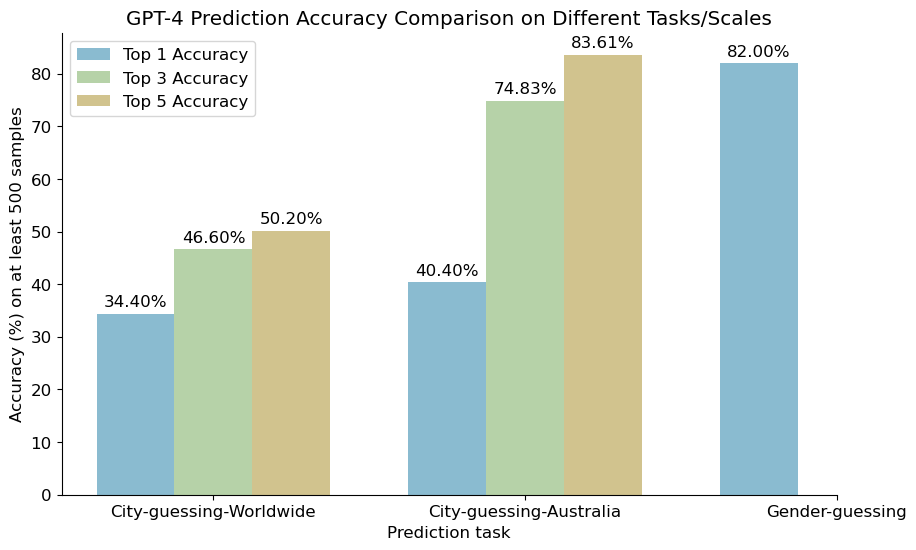

In [58]:


# Dataset names
datasets = ['City-guessing-Worldwide', 'City-guessing-Australia', 'Gender-guessing']

# Accuracy data
top1 = np.array([34.4, 40.4, 82.0])  # Top 1 accuracies
top3 = np.array([46.6, 74.83, np.nan])     # Top 3 accuracies, missing data for gender-guessing set to 0
top5 = np.array([50.2, 83.61, np.nan])     # Top 5 accuracies, missing data for gender-guessing set to 0

# Set the pastel color palette
colors = ['#8abbd0', '#b6d2a8', '#d1c38e']

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Location of the bars on the x-axis
ind = np.arange(len(datasets))

# Width of the bars
width = 0.25

# Plotting bars for top1, top3, and top5 accuracies
bars1 = ax.bar(ind - width, top1, width, label='Top 1 Accuracy', color=colors[0])
bars2 = ax.bar(ind, top3, width, label='Top 3 Accuracy', color=colors[1])
bars3 = ax.bar(ind + width, top5, width, label='Top 5 Accuracy', color=colors[2])


# Function to add labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):  # Only add label if the height is not NaN
            ax.annotate(f'{height:.2f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords='offset points',
                        ha='center', va='bottom')

# Call the function to add labels on the bars
add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

# Set the labels for the x ticks
ax.set_xticks(ind)
ax.set_xticklabels(datasets)

# Removing the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Set the axis labels and title
ax.set_xlabel('Prediction task')
ax.set_ylabel('Accuracy (%) on at least 500 samples')
ax.set_title('GPT-4 Prediction Accuracy Comparison on Different Tasks/Scales')

# Adding a legend
ax.legend()

# Display the plot
plt.show()